# Imports

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sktime.transformations.panel.rocket import MultiRocketMultivariate
from sktime.transformations.panel.rocket import MultiRocket
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sktime.classification.deep_learning import InceptionTimeClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.compose import ColumnEnsembleClassifier
from sklearn import preprocessing
import torch.nn as nn
from sktime.regression.kernel_based import RocketRegressor
from sktime.regression.compose import ComposableTimeSeriesForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve,roc_auc_score
import sys
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader
from scipy import stats, signal
import scipy.interpolate as interp
import joblib
import math
from sktime.transformations.series.fourier import FourierTransform

# Defined Functions

In [3]:
def from_2d_array_to_nested(X, index=None, columns=None, time_index=None, cells_as_numpy=False):
    """Convert 2D dataframe to nested dataframe.
    Convert tabular pandas DataFrame with only primitives in cells into
    nested pandas DataFrame with a single column.
    Parameters
    ----------
    X : pd.DataFrame
    cells_as_numpy : bool, default = False
        If True, then nested cells contain NumPy array
        If False, then nested cells contain pandas Series
    index : array-like, shape=[n_samples], optional (default = None)
        Sample (row) index of transformed DataFrame
    time_index : array-like, shape=[n_obs], optional (default = None)
        Time series index of transformed DataFrame
    Returns
    -------
    Xt : pd.DataFrame
        Transformed DataFrame in nested format
    """
    if (time_index is not None) and cells_as_numpy:
        raise ValueError(
            "`Time_index` cannot be specified when `return_arrays` is True, "
            "time index can only be set to "
            "pandas Series"
        )
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    container = np.array if cells_as_numpy else pd.Series

    # for 2d numpy array, rows represent instances, columns represent time points
    n_instances, n_timepoints = X.shape

    if time_index is None:
        time_index = np.arange(n_timepoints)
    kwargs = {"index": time_index}

    Xt = pd.DataFrame(
        pd.Series([container(X[i, :], **kwargs) for i in range(n_instances)])
    )
    if index is not None:
        Xt.index = index
    if columns is not None:
        Xt.columns = columns
    return Xt

def best_indices(coef, x=2000, twoD=True):

    # Create a boolean array of coefficients that are greater than or equal to 0.002

    abs_coef = np.abs(coef)

    sorted_indices = np.argsort(abs_coef)  
    if twoD == True:# indices of the x largest coefficients
    #top_x_indices = top_x_indices.iloc[0,-x:]
        topx=[]
        for i in np.arange(0,sorted_indices.shape[0]):
            top_x_indices = sorted_indices.reshape(-1)
            top_x_indices = top_x_indices[-x:]
            topx.append(top_x_indices)
        top_x_indices = np.concatenate(topx)
    else:
        top_x_indices = sorted_indices.reshape(-1)
        top_x_indices = top_x_indices[-x:]
    top_x_indices.sort()
    top_x_indices = np.unique(top_x_indices)
    return top_x_indices

def data_splitting(df_list, torque, speed,label, l=1):
    split_data = []
    torque_split = []
    speed_split = []
    label_split = []
    index_split = []
    counter=0
    for j, df in enumerate(df_list):
        counter += 1
        tmp = 0
        indices = np.where(np.array(df)[:, 3] == 1)
        if speed[j] in [100,300]:
            reset=l
        elif speed[j] in [200,400, 500, 600, 1200]:
            reset=l-1    
        elif speed[j] in [700, 800]:
            reset=l-2  
        elif speed[j] ==900:
            reset=l-3     
        else:
            reset=l-4    
        for i, index in enumerate(indices[0]):
            if tmp<l:
                tmp = tmp+1
            else:
                
                split_data.append(np.array(df.iloc[indices[0][i-l]:index, [0, 1, 2]]))
                torque_split.append(torque[j])
                speed_split.append(speed[j])
                label_split.append(label[j])
                index_split.append(counter)
                
                tmp=reset
    #split_data = np.concatenate(split_data, axis=2)  
    return split_data, speed_split, torque_split, label_split, index_split

def data_splitting_test(df_list, torque, speed, l=1):
    split_data = []
    torque_split = []
    speed_split = []
    label_split = []
    index_split = []
    counter=0
    for j, df in enumerate(df_list):
        counter += 1
        tmp = 0
        indices = np.where(np.array(df)[:, 3] == 1)
        if speed[j] in [100,300]:
            reset=l
        elif speed[j] in [200,400, 500, 600, 1200]:
            reset=l-1    
        elif speed[j] in [700, 800]:
            reset=l-2  
        elif speed[j] ==900:
            reset=l-3     
        else:
            reset=l-4    
        for i, index in enumerate(indices[0]):
            if tmp<l:
                tmp = tmp+1
            else:
                
                split_data.append(np.array(df.iloc[indices[0][i-l]:index, [0, 1, 2]]))
                torque_split.append(torque[j])
                speed_split.append(speed[j])

                index_split.append(counter)
                
                tmp=reset
    #split_data = np.concatenate(split_data, axis=2)  
    return split_data, speed_split, torque_split, index_split

def get_additional_features(split, torque, speed):
    additional_features = []
    for i,ts in enumerate(split):
        stats_df = []
        speed_torque_dict = {
        'speed_1': speed[i],
        'torque_1': torque[i]}
        speed_torque_df = pd.DataFrame.from_dict(speed_torque_dict, orient='index', columns=['Value'])
        for i in range(ts.shape[1]):

            mean = np.mean(ts[:,i])
            std_dev = np.std(ts[:,i])
            variance = np.var(ts[:,i])
            skewness = stats.skew(ts[:,i])
            kurtosis = stats.kurtosis(ts[:,i])
            autocorr = pd.Series(ts[:,i]).autocorr(lag=1)
            frequencies, density = signal.welch(ts[:,i], nperseg=256)
            density_df = pd.DataFrame(density.transpose()).transpose()
            outlier_list = []
            for j in [1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4, 4.25,4.5, 4.75, 5, 5.25,5.5,5.75,6]:
                threshold = j * std_dev
                nmb_outliers = np.sum(np.abs(ts[:,i] - mean) > threshold)
                outlier_list.append(nmb_outliers)
            outlier_df = pd.DataFrame([outlier_list])
            stats_dict = {
            'Mean': mean,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Auto-correlation (lag 1)': autocorr}
            stats_dict = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['0']).reset_index(drop=True).transpose()
            density_df = density_df.reset_index(drop=True)
            stats_dict.index = density_df.index
            outlier_df.index = density_df.index
            stats_df.append(pd.concat([stats_dict, density_df, outlier_df], axis=1))
        additional_features.append(np.concatenate([np.array(speed_torque_df.transpose()), np.concatenate(stats_df, axis=1)], axis=1))


    # Create a DataFrame from the dictionary
    #stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['Value'])
    return additional_features

def get_additional_features2(split, torque, speed):
    additional_features = []
    for i,ts in enumerate(split):
        stats_df = []

        speed_torque_dict = {
        'speed_1': speed[i],
        'torque_1': torque[i]}

        speed_torque_df = pd.DataFrame.from_dict(speed_torque_dict, orient='index', columns=['Value'])
        for i in range(ts.shape[1]):

            mean = np.mean(ts[i])
            std_dev = np.std(ts[i])
            variance = np.var(ts[i])
            skewness = stats.skew(ts[i])
            kurtosis = stats.kurtosis(ts[i])
            autocorr = pd.Series(ts[i]).autocorr(lag=1)
            frequencies, density = signal.welch(ts[i], nperseg=256)
            density_df = pd.DataFrame(density.transpose()).transpose()
            outlier_list = []
            for j in [1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4, 4.25,4.5, 4.75, 5, 5.25,5.5,5.75,6]:
                threshold = j * std_dev
                nmb_outliers = np.sum(np.abs(ts[i] - mean) > threshold)
                outlier_list.append(nmb_outliers)
            outlier_df = pd.DataFrame([outlier_list])
            stats_dict = {
            'Mean': mean,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Auto-correlation (lag 1)': autocorr}
            stats_dict = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['0']).reset_index(drop=True).transpose()
            density_df = density_df.reset_index(drop=True)
            stats_dict.index = density_df.index
            outlier_df.index = density_df.index
            stats_df.append(pd.concat([stats_dict, density_df, outlier_df], axis=1))
        additional_features.append(np.concatenate([np.array(speed_torque_df.transpose()), np.concatenate(stats_df, axis=1)], axis=1))


    # Create a DataFrame from the dictionary
    #stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['Value'])
    return additional_features
def interpolate_dataframes(array_list, l=1):
    target_length = 3687 * l
    new_list = []

    for i, arr in enumerate(array_list):
        arr_1 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_1 = arr_1(np.linspace(0,arr[:,0].size-1,target_length))
        arr_2 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_2 = arr_2(np.linspace(0,arr[:,0].size-1,target_length))
        arr_3 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_3 = arr_3(np.linspace(0,arr[:,0].size-1,target_length))
        interpolated_array = np.concatenate([arr_1.reshape(-1,1), arr_2.reshape(-1,1), arr_3.reshape(-1,1)], axis=1)
        new_list.append(interpolated_array)

    return new_list

def cut_dataframes(array_list, Drehzahl_list, l=1):
    
    new_list = []
    factor = 120/216
    for i, arr in enumerate(array_list):

        speed = Drehzahl_list[i]
        if speed in [100,200]:
            time=12
        elif speed in [300,400,500,600,700,800,900,1000]:
            time =6
        else:
            time=3         
        target_length = int((l/((speed/60) * factor)) * 20480)

        if len(arr)>=target_length:
            arr = arr[:target_length,:]
        else:
            zeros_to_append = target_length - len(arr)
            zeros_df = pd.DataFrame(0, index=range(zeros_to_append), columns=pd.DataFrame(arr).columns)
            arr = pd.concat([pd.DataFrame(arr), zeros_df])
        new_list.append(arr)

    return new_list

def cut_dataframes_all(array_list, Drehzahl_list):
    
    new_list = []
    factor = 120/216
    for i, arr in enumerate(array_list):

        speed = Drehzahl_list[i]
        if speed in [100,200]:
            time=12
        elif speed in [300,400,500,600,700,800,900,1000]:
            time =6
        else:
            time=3         
        l = math.floor((speed/60) * factor * time)
        target_length = int((l/((speed/60) * factor)) * 20480)
        
        if len(arr)>=target_length:
            arr = pd.DataFrame(np.array(arr)[:target_length,:])
        else:
            zeros_to_append = target_length - len(arr)
            zeros_df = pd.DataFrame(0, index=range(zeros_to_append), columns=pd.DataFrame(arr).columns)
            arr = pd.concat([arr, zeros_df])
        new_list.append(arr)

    return new_list

# Load Data

In [3]:
train_path = "D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0"
dataframes = []
torque = []
speed = []
label=[]
for file_name in os.listdir(train_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(train_path, file_name)
        
        with open(file_path, "r") as file:
            content = file.read()

                # Extract numbers from the file name
        speed_number = int(file_name.split("_")[0][1:])
        torque_number = int(file_name.split("_")[1][:-1])
        
        # Save the numbers
        speed.append(speed_number)
        torque.append(torque_number)
        label.append(1)
        
        df = pd.read_csv(file_path, delimiter=' ', header = None)
        dataframes.append(df)

# for i in np.arange(0,len(dataframes)):
#     df_2d = dataframes[i].transpose()
#     df_nested = from_2d_array_to_nested(df_2d)
#     df1 = df_nested.transpose()
#     if i ==0:
#         df=df1
#     else: 
#         df = pd.concat([df,df1], axis=0)
# df.reset_index(inplace=True, drop=True)

In [4]:
train_path = "C:/PHM_2023_Datadump/traininterpolated"
dataframes = []
for file_name in os.listdir(train_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(train_path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)
for i in np.arange(0,len(dataframes)):
    df_high_2d = dataframes[i].transpose()
    df_high_nested = from_2d_array_to_nested(df_high_2d)
    df_high1 = df_high_nested.transpose()
    if i ==0:
        df_high=df_high1
    else: 
        df_high = pd.concat([df_high,df_high1], axis=0)
df_high.reset_index(inplace=True, drop=True)

KeyboardInterrupt: 

In [ ]:
train_path = "C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)"
dataframes = []
valid_versions = ["V1200", "V1500", "V1800", "V2100", "V2400", "V2700", "V3000", "V3600"]

for file_name in os.listdir(train_path):
    if any(version in file_name for version in valid_versions):
        file_path = os.path.join(train_path, file_name)
        with open(file_path, "r") as file:
            content = file.read()
        df_high = pd.read_csv(file_path, delimiter=' ', header = None)
        dataframes.append(df_high)

for i in np.arange(0,len(dataframes)):
    df_high_2d = dataframes[i].transpose()
    df_high_nested = from_2d_array_to_nested(df_high_2d)
    df_high1 = df_high_nested.transpose()
    if i ==0:
        df_high=df_high1
    else: 
        df_high = pd.concat([df_high,df_high1], axis=0)
df_high.reset_index(inplace=True, drop=True)

In [ ]:
train_path = "C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)"
dataframes = []
valid_versions = ["V100_"]

for file_name in os.listdir(train_path):
    if any(version in file_name for version in valid_versions):
        file_path = os.path.join(train_path, file_name)
        print(file_path)
        with open(file_path, "r") as file:
            content = file.read()
        df_high = pd.read_csv(file_path, delimiter=' ', header = None)
        dataframes.append(df_high)

for i in np.arange(0,len(dataframes)):
    df_high_2d = dataframes[i].transpose()
    df_high_nested = from_2d_array_to_nested(df_high_2d)
    df_high1 = df_high_nested.transpose()
    if i ==0:
        df_high=df_high1
    else: 
        df_high = pd.concat([df_high,df_high1], axis=0)
df_high.reset_index(inplace=True, drop=True)

C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_100N_1.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_100N_2.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_100N_3.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_100N_5.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_200N_1.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_200N_2.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_200N_4.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)\V100_200N_5.txt
C:/Users/je009447/Downloads/Data_Challenge_PHM20

# Visualizations

6


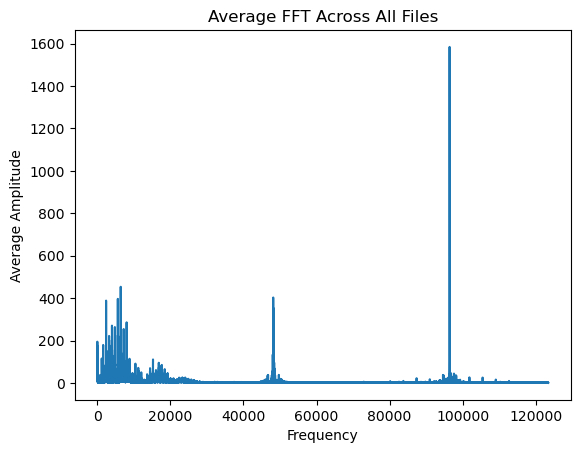

In [17]:
fft_results = []
for i in [0,1,2,3,4,6,8]:
    print(i)
    data_path = f"D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_{i}"
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"V100_50N"):
            file_path = os.path.join(data_path, file_name)  
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            transformer = FourierTransform()
            X_ft = transformer.fit_transform(df.iloc[:-1])
            fft_result = np.abs(X_ft[0])  # Use the first transformed feature
            
            # Add FFT result to the array
            fft_results.append(fft_result)

# Convert the FFT results array to a numpy array
fft_results = np.array(fft_results)

# Calculate the average FFT value for each point across all files
average_fft = np.mean(fft_results, axis=0)

# Plot the average FFT
plt.plot(average_fft)
plt.xlabel('Frequency')
plt.ylabel('Average Amplitude')
plt.title('Average FFT Across All Files')
plt.show()


Processing degradation level 0
Processing degradation level 1
Processing degradation level 2
Processing degradation level 3
Processing degradation level 4
Processing degradation level 6
Processing degradation level 8


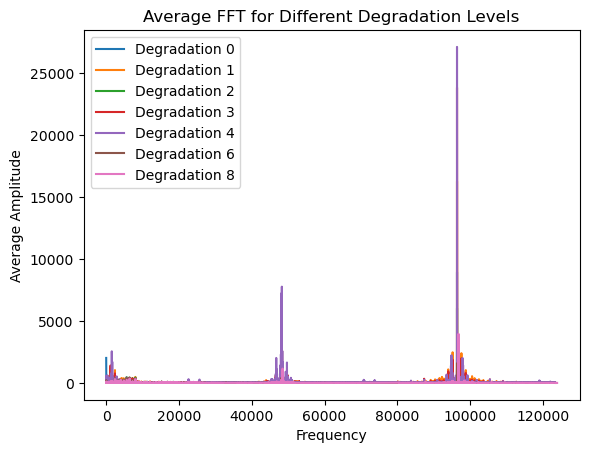

In [18]:
degradation_levels = [0, 1, 2, 3, 4, 6, 8]

# Initialize an empty dictionary to store FFT results for each degradation level
fft_results_by_degradation = {i: [] for i in degradation_levels}

# Loop through each degradation level
for i in degradation_levels:
    print(f"Processing degradation level {i}")
    data_path = f"D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_{i}"
    
    # Loop through files in the current degradation level folder
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"V100_50N"):
            file_path = os.path.join(data_path, file_name)  
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            
            # Apply FFT using the provided transformer
            transformer = FourierTransform()
            X_ft = transformer.fit_transform(df.iloc[:-1])
            fft_result = np.abs(X_ft[0])  # Use the first transformed feature
            
            # Add FFT result to the corresponding degradation level
            fft_results_by_degradation[i].append(fft_result)

# Calculate the average FFT value for each degradation level
average_ffts = {}
for i in degradation_levels:
    fft_results = np.array(fft_results_by_degradation[i])
    average_fft = np.mean(fft_results, axis=0)
    average_ffts[i] = average_fft

# Plot the average FFT for each degradation level
for i in degradation_levels:
    plt.plot(average_ffts[i], label=f'Degradation {i}')
    
plt.xlabel('Frequency')
plt.ylabel('Average Amplitude')
plt.title('Average FFT for Different Degradation Levels')
plt.legend()
plt.show()

Processing degradation level 0
Processing degradation level 6
Processing degradation level 8
                          0             1             2             3  \
Frequency      48135.000000  96401.000000  96398.000000  96400.000000   
Degradation_0   2069.459763   2246.369656   2549.310764   6071.681908   
Degradation_6    402.895054    347.667830    421.063086    870.496778   
Degradation_8      2.535668      4.923545      4.480903      5.481956   

                          4  
Frequency      96399.000000  
Degradation_0   8924.941355  
Degradation_6   1584.648748  
Degradation_8      4.031841  


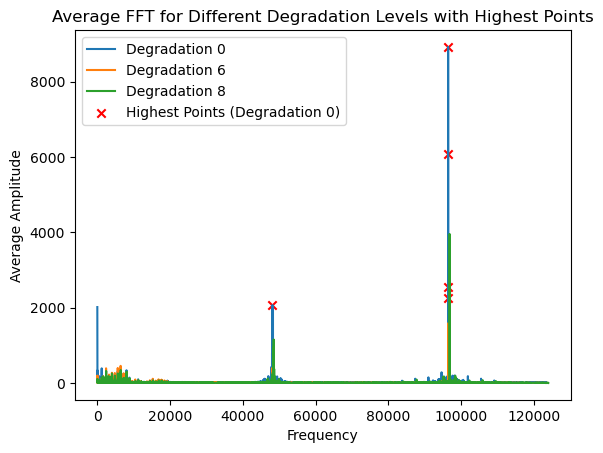

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import zscore

# List of degradation levels
degradation_levels = [0, 6, 8]

# Initialize an empty dictionary to store FFT results for each degradation level
fft_results_by_degradation = {i: [] for i in degradation_levels}

# Loop through each degradation level
for i in degradation_levels:
    print(f"Processing degradation level {i}")
    data_path = f"D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_{i}"
    
    # Loop through files in the current degradation level folder
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"V100_50N"):
            file_path = os.path.join(data_path, file_name)  
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            
            # Apply FFT using the provided transformer
            transformer = FourierTransform()
            X_ft = transformer.fit_transform(df.iloc[:-1])
            fft_result = np.abs(X_ft[0])  # Use the first transformed feature
            
            # Add FFT result to the corresponding degradation level
            fft_results_by_degradation[i].append(fft_result)

# Calculate the average FFT value for each degradation level
average_ffts = {}
for i in degradation_levels:
    fft_results = np.array(fft_results_by_degradation[i])
    average_fft = np.mean(fft_results, axis=0)
    average_ffts[i] = average_fft

# Find the indices of the highest 5 points in degradation state 0
highest_indices = np.argsort(average_ffts[0])[-5:]

# Create a DataFrame to store the highest points for each degradation state
highest_points_df = pd.DataFrame(columns=['Frequency'] + [f'Degradation_{i}' for i in degradation_levels])
highest_points_df['Frequency'] = highest_indices

# Fill in the highest points for each degradation state
for i in degradation_levels:
    highest_points_df[f'Degradation_{i}'] = average_ffts[i][highest_indices]

# Display the DataFrame with highest points
print(highest_points_df.transpose())

# Plot the average FFT for each degradation level
for i in degradation_levels:
    plt.plot(average_ffts[i], label=f'Degradation {i}')
    
plt.scatter(highest_indices, highest_points_df['Degradation_0'], color='red', marker='x', label='Highest Points (Degradation 0)')
plt.xlabel('Frequency')
plt.ylabel('Average Amplitude')
plt.title('Average FFT for Different Degradation Levels with Highest Points')
plt.legend()
plt.show()

Processing degradation level 0
Processing degradation level 1
Processing degradation level 2
Processing degradation level 3
Processing degradation level 4
Processing degradation level 6
Processing degradation level 8


TypeError: only integer scalar arrays can be converted to a scalar index

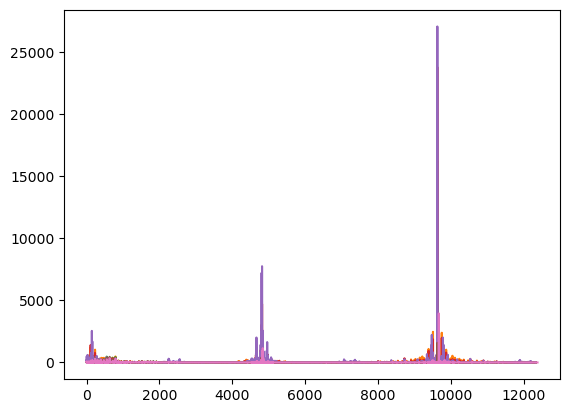

In [26]:

# List of degradation levels
degradation_levels = [0, 1, 2, 3, 4, 6, 8]

# Initialize an empty dictionary to store FFT results for each degradation level
fft_results_by_degradation = {i: [] for i in degradation_levels}

# Loop through each degradation level
for i in degradation_levels:
    print(f"Processing degradation level {i}")
    data_path = f"D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_{i}"
    
    # Loop through files in the current degradation level folder
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"V100_50N"):
            file_path = os.path.join(data_path, file_name)  
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            
            # Apply FFT using the provided transformer
            transformer = FourierTransform()
            X_ft = transformer.fit_transform(df.iloc[:-1])
            fft_result = np.abs(X_ft[0])  # Use the first transformed feature
            
            # Add FFT result to the corresponding degradation level
            fft_results_by_degradation[i].append(fft_result)

# Calculate the average FFT value for each degradation level
average_ffts = {}
for i in degradation_levels:
    fft_results = np.array(fft_results_by_degradation[i])
    average_fft = np.mean(fft_results, axis=0)
    average_ffts[i] = average_fft

# Find the indices of the highest 5 points in degradation state 0
highest_indices = np.argsort(average_ffts[0])[-5:]

# Create a DataFrame to store the highest points for each degradation state
highest_points_df = pd.DataFrame(columns=['Frequency'] + [f'Degradation_{i}' for i in degradation_levels])
highest_points_df['Frequency'] = highest_indices

# Fill in the highest points for each degradation state
for i in degradation_levels:
    highest_points_df[f'Degradation_{i}'] = average_ffts[i][highest_indices]

# Bin the FFT values by replacing 10 values with the highest value within each bin
binned_ffts = {}
bin_size = 10
for i in degradation_levels:
    num_bins = len(average_ffts[i]) // bin_size
    binned_fft = [np.max(average_ffts[i][j:j+bin_size]) for j in range(0, len(average_ffts[i]), bin_size)]
    binned_ffts[i] = binned_fft

# Cut the first 10 values from the binned FFTs
for i in degradation_levels:
    binned_ffts[i] = binned_ffts[i][10:]

# Plot the binned FFT for each degradation level
for i in degradation_levels:
    plt.plot(binned_ffts[i], label=f'Degradation {i}')
highest_indices = np.argsort(binned_ffts[0])[-5:]

# Create a DataFrame to store the highest points for each degradation state
highest_points_df = pd.DataFrame(columns=['Frequency'] + [f'Degradation_{i}' for i in degradation_levels])
highest_points_df['Frequency'] = highest_indices

# Fill in the highest points for each degradation state
for i in degradation_levels:
    highest_points_df[f'Degradation_{i}'] = binned_ffts[i][highest_indices]

# Display the DataFrame with highest points
print(highest_points_df.transpose())
    
plt.xlabel('Frequency')
plt.ylabel('Binned Average Amplitude')
plt.title('Binned Average FFT for Different Degradation Levels')
plt.legend()
plt.show()



In [62]:
degradation_levels = [0,1,2,3,4,6,8]

# Initialize an empty dictionary to store FFT results for each degradation level
fft_results_by_degradation = {i: [] for i in degradation_levels}

# Loop through each degradation level
for i in degradation_levels:
    print(f"Processing degradation level {i}")
    data_path = f"D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_{i}"
    
    # Loop through files in the current degradation level folder
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"V100_50N"):
            file_path = os.path.join(data_path, file_name)  
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            
            # Apply FFT using the provided transformer
            transformer = FourierTransform()
            X_ft = transformer.fit_transform(df.iloc[:-1])
            fft_result = np.abs(X_ft[0])  # Use the first transformed feature
            
            # Add FFT result to the corresponding degradation level
            fft_results_by_degradation[i].append(fft_result)

Processing degradation level 0
Processing degradation level 1
Processing degradation level 2
Processing degradation level 3
Processing degradation level 4
Processing degradation level 6
Processing degradation level 8


c:\Users\janni\anaconda3\envs\python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\janni\anaconda3\envs\python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\janni\anaconda3\envs\python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\janni\anaconda3\envs\python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\janni\anaconda3\envs\python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\janni\anaconda3\envs\python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning

Empty DataFrame
Columns: [index_0]
Index: []


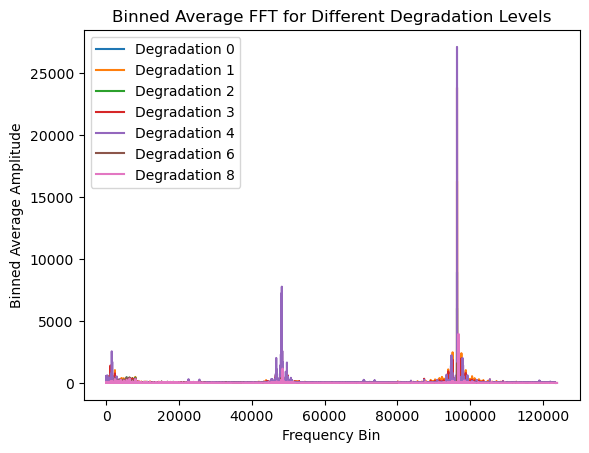

In [65]:
average_ffts = {}
for i in degradation_levels:
    fft_results = np.array(fft_results_by_degradation[i])
    average_fft = np.mean(fft_results, axis=0)
    average_ffts[i] = average_fft



# Cut the first 10 values from the binned FFTs
for i in degradation_levels:
    fft_results_by_degradation[i] = fft_results_by_degradation[i][10:]
fft_results_by_degradation[i]
# Find the indices of the highest 5 points in degradation state 0
highest_indices = np.argsort(average_ffts[0])[-10:]

# Ensure minimum distance between selected indices
min_distance = 6  # Set the minimum distance between selected indices

selected_indices = []
for idx in highest_indices:
    if all(abs(idx - s_idx) >= min_distance for s_idx in selected_indices):
        selected_indices.append(idx)
        if len(selected_indices) == 5:
            break

# Create a DataFrame to store the highest points for each degradation state
highest_points_df = pd.DataFrame(columns=[f'index_{i}' for i in selected_indices])


# Fill in the highest points for each degradation state
for i in fft_results_by_degradation[i]:
    for j in fft_results_by_degradation[i][j]:
        selected_values = []
        for idx in selected_indices:
            range_start = max(0, idx - 500)  # Ensures the range doesn't go below index 0
            range_end = min(len(binned_ffts[i]) - 1, idx +500)  # Ensures the range doesn't go beyond the array length
            max_value_in_range = max(binned_ffts[i][range_start:range_end+1])
            selected_values.append(max_value_in_range)
        highest_points_df[f'Degradation_{i}'] = selected_values
highest_points_df = highest_points_df.drop_duplicates()
# Display the DataFrame with highest points
print(highest_points_df)

# Plot the binned FFT for each degradation level
for i in degradation_levels:
    plt.plot(binned_ffts[i], label=f'Degradation {i}')
    
plt.xlabel('Frequency Bin')
plt.ylabel('Binned Average Amplitude')
plt.title('Binned Average FFT for Different Degradation Levels')
plt.legend()
plt.show()

Processing degradation level 0
Processing degradation level 1
Processing degradation level 2
Processing degradation level 3
Processing degradation level 4
Processing degradation level 6
Processing degradation level 8


C:\Users\janni\AppData\Local\Temp\ipykernel_23844\2386785067.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highest_points_df = highest_points_df.append(df_degradation, ignore_index=True)
C:\Users\janni\AppData\Local\Temp\ipykernel_23844\2386785067.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highest_points_df = highest_points_df.append(df_degradation, ignore_index=True)
C:\Users\janni\AppData\Local\Temp\ipykernel_23844\2386785067.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highest_points_df = highest_points_df.append(df_degradation, ignore_index=True)
C:\Users\janni\AppData\Local\Temp\ipykernel_23844\2386785067.py:57: FutureWarning: The frame.append method is deprecated and will be removed from panda

   Degradation_State Frequency Degradation_0 Degradation_1 Degradation_2  \
0                  0     96393           NaN           NaN           NaN   
1                  0     48253           NaN           NaN           NaN   
2                  0     48125           NaN           NaN           NaN   
3                  1     97595           NaN           NaN           NaN   
4                  1     48254           NaN           NaN           NaN   
5                  1     95184           NaN           NaN           NaN   
6                  1     48311           NaN           NaN           NaN   
7                  1     96392           NaN           NaN           NaN   
8                  2     96386           NaN           NaN           NaN   
9                  2     48254           NaN           NaN           NaN   
10                 2     48125           NaN           NaN           NaN   
11                 2     48311           NaN           NaN           NaN   
12          

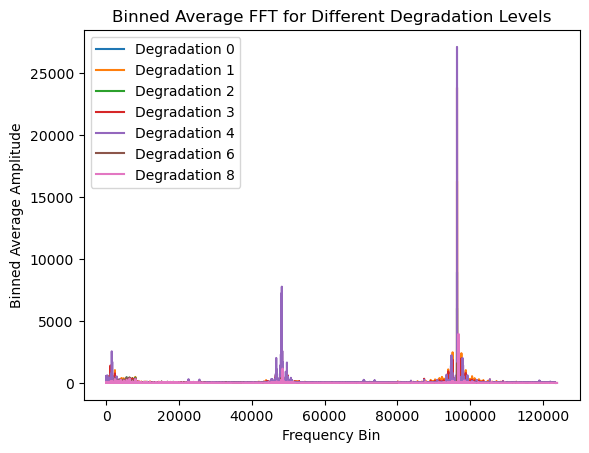

In [55]:
degradation_levels = [0,1,2,3,4,6,8]

# Initialize an empty dictionary to store FFT results for each degradation level
fft_results_by_degradation = {i: [] for i in degradation_levels}

# Loop through each degradation level
for i in degradation_levels:
    print(f"Processing degradation level {i}")
    data_path = f"D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_{i}"
    
    # Loop through files in the current degradation level folder
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"V100_50N"):
            file_path = os.path.join(data_path, file_name)  
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            
            # Apply FFT using the provided transformer
            transformer = FourierTransform()
            X_ft = transformer.fit_transform(df.iloc[:-1])
            fft_result = np.abs(X_ft[0])  # Use the first transformed feature
            
            # Add FFT result to the corresponding degradation level
            fft_results_by_degradation[i].append(fft_result)
highest_points_df = pd.DataFrame(columns=['Degradation_State', 'Frequency'] + [f'Degradation_{i}' for i in degradation_levels])

# Fill in the highest points for each degradation state
for i in degradation_levels:
    highest_indices = np.argsort(binned_ffts[i])[-10:]  # Modify the number of highest points to extract
    
    # Ensure minimum distance between selected indices
    min_distance = 11  # Set the minimum distance between selected indices

    selected_indices = []
    for idx in highest_indices:
        if all(abs(idx - s_idx) >= min_distance for s_idx in selected_indices):
            selected_indices.append(idx)
            if len(selected_indices) == 5:
                break
    
    selected_values = []
    for idx in selected_indices:
        range_start = max(0, idx - 500)
        range_end = min(len(binned_ffts[i]) - 1, idx + 500)
        max_value_in_range = max(binned_ffts[i][range_start:range_end + 1])
        selected_values.append(max_value_in_range)
    
    degradation_state_column = [i] * len(selected_values)  # Create a column for degradation state
    
    data = {'Degradation_State': degradation_state_column,
            'Frequency': selected_indices}
    
    # Add the highest point columns to the data dictionary
    for j, value in enumerate(selected_values):
        data[f'Degradation_{i}_{j}'] = value
    
    df_degradation = pd.DataFrame(data)
    highest_points_df = highest_points_df.append(df_degradation, ignore_index=True)

# Display the DataFrame with highest points
print(highest_points_df)

# Plot the binned FFT for each degradation level
for i in degradation_levels:
    plt.plot(binned_ffts[i], label=f'Degradation {i}')
    
plt.xlabel('Frequency Bin')
plt.ylabel('Binned Average Amplitude')
plt.title('Binned Average FFT for Different Degradation Levels')
plt.legend()
plt.show()

8


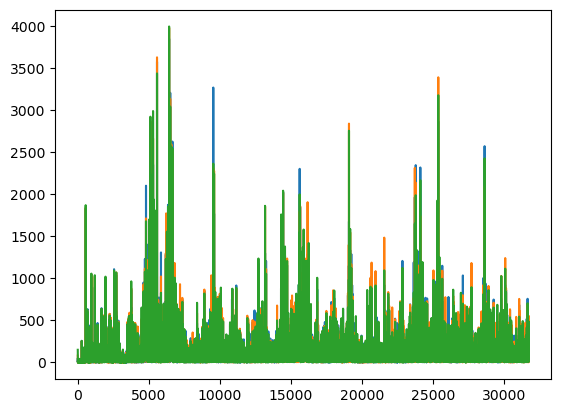

In [94]:
for i in [8]:
    print(i)
    data_path = f"D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_{i}"
    for file_name in os.listdir(data_path):
        if file_name.startswith(f"V2700_50N_"):
            file_path = os.path.join(data_path, file_name)  
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            transformer = FourierTransform()
            X_ft = transformer.fit_transform(df.iloc[:-1])
            plt.plot(X_ft[0])

In [7]:
df_V100_50N_1 = pd.read_csv("D:\Projects\PHM_2023\Data_Challenge_PHM2023_training_data\Pitting_degradation_level_1/V100_50N_1.txt", delimiter=' ', header=None)


In [11]:
from sktime.transformations.series.fourier import FourierTransform
transformer = FourierTransform()
X_ft = transformer.fit_transform(df_V100_50N_1.iloc[:-1])

In [10]:
df_V100_50N_1[0]

0         0.226153
1        -0.200845
2         0.181989
3        -0.089816
4        -0.343261
            ...   
246780    0.148246
246781   -0.096515
246782    0.038209
246783    0.054088
246784         NaN
Name: 0, Length: 246785, dtype: float64

c:\Users\janni\anaconda3\envs\python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


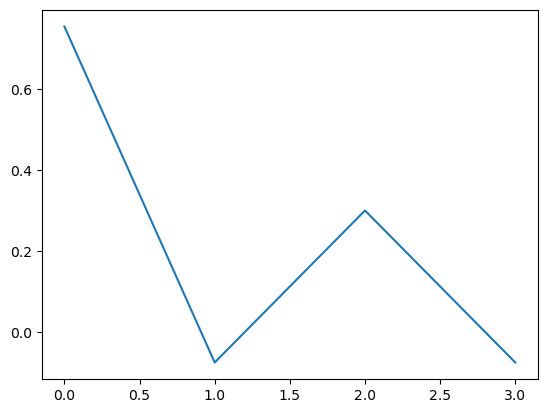

In [18]:
p=np.fft.fft(df_V100_50N_1.iloc[:-1])
plt.plot(p[0])

In [12]:
X_ft

,0,1,2,3
0,17.501420,16.039252,16.688461,0.136573
1,71.700445,19.673114,70.648186,0.142458
2,31.954221,87.345317,70.644510,0.150941
3,72.803927,53.595040,106.644632,0.168160
4,13.125699,27.710098,72.485342,0.190669
...,...,...,...,...
123387,1.487747,1.054256,4.303420,3.546956
123388,2.077853,1.827655,4.790333,2.325124
123389,2.371932,3.939947,2.885883,1.750250
123390,0.731530,2.321094,6.148703,2.928321


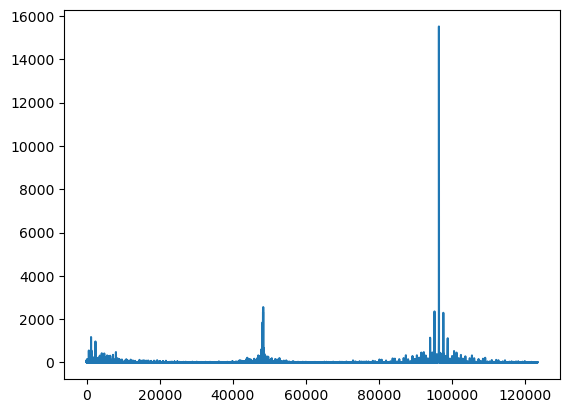

In [12]:
plt.plot(X_ft[0])

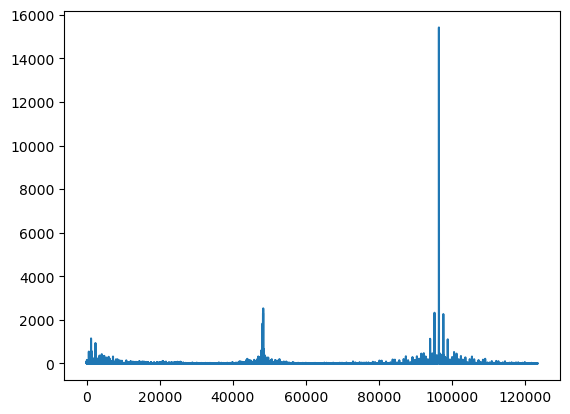

In [15]:
plt.plot(X_ft[1])

In [19]:
import numpy as np

# Example data and indices
labels = np.arange(25)  # Example labels from 0 to 24
indices_to_move = np.array([16, 23])  # Example indices to remove

# Drop rows with label 2 from df and labels
labels = np.delete(labels, indices_to_move)

print(labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 24]


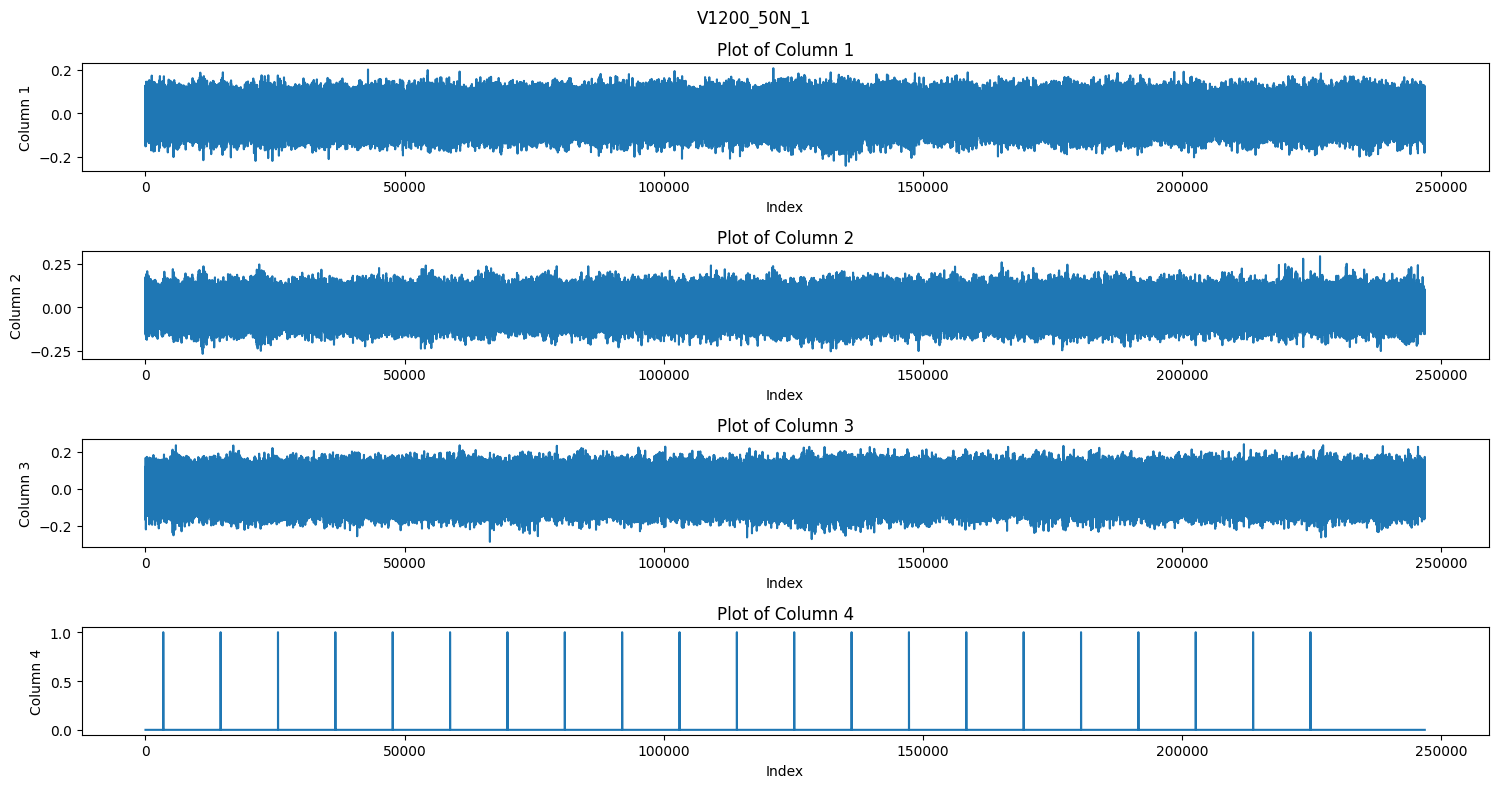

In [19]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V1200_50N_1.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V1200_50N_1.columns):
    axes[i].plot(df_V1200_50N_1[column])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

plt.suptitle('V1200_50N_1')
plt.tight_layout()

# Display the plots
plt.show()

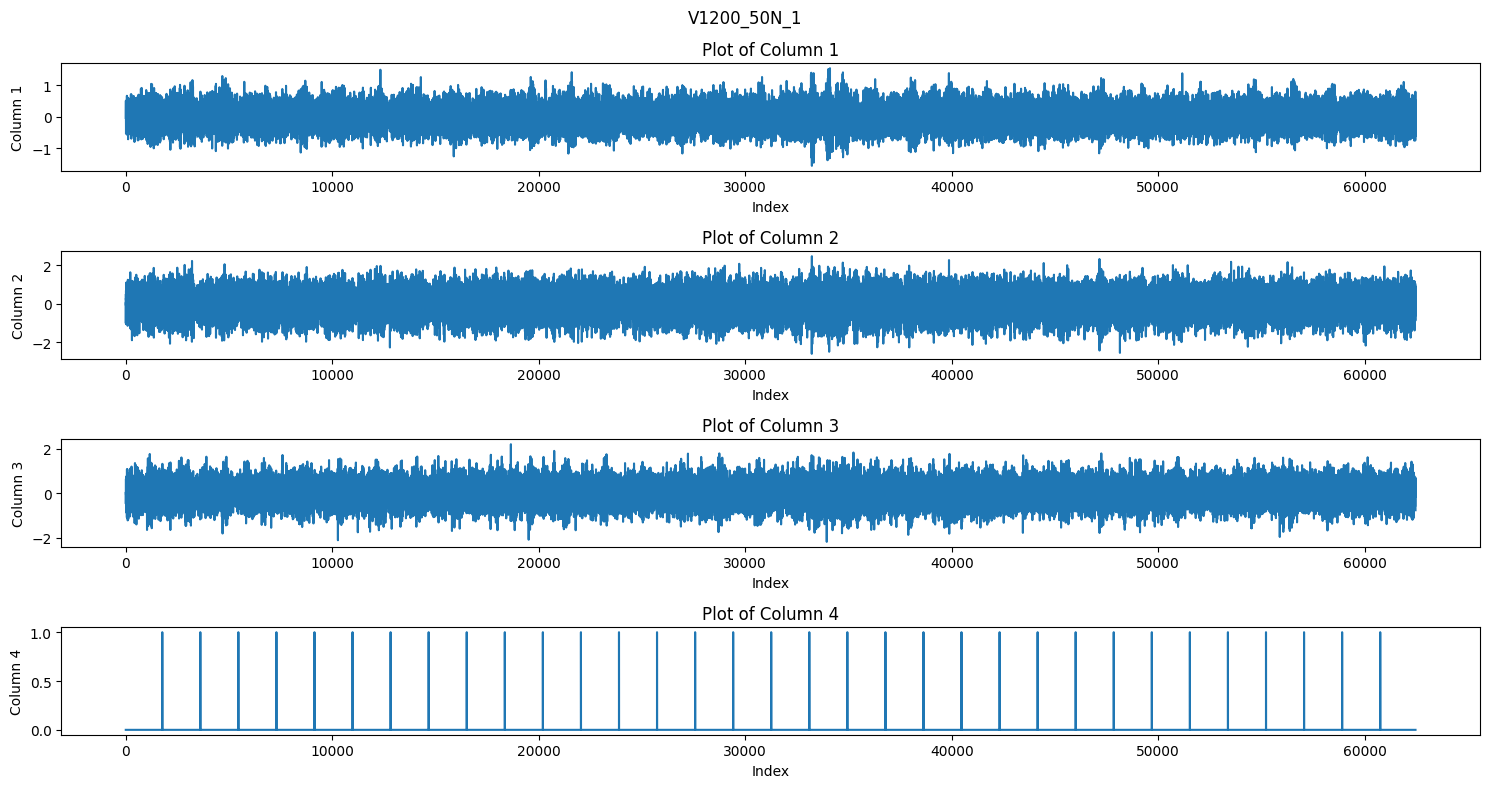

In [15]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V1200_50N_1.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V1200_50N_1.columns):
    axes[i].plot(df_V1200_50N_1[column])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

plt.suptitle('V1200_50N_1')
plt.tight_layout()

# Display the plots
plt.show()

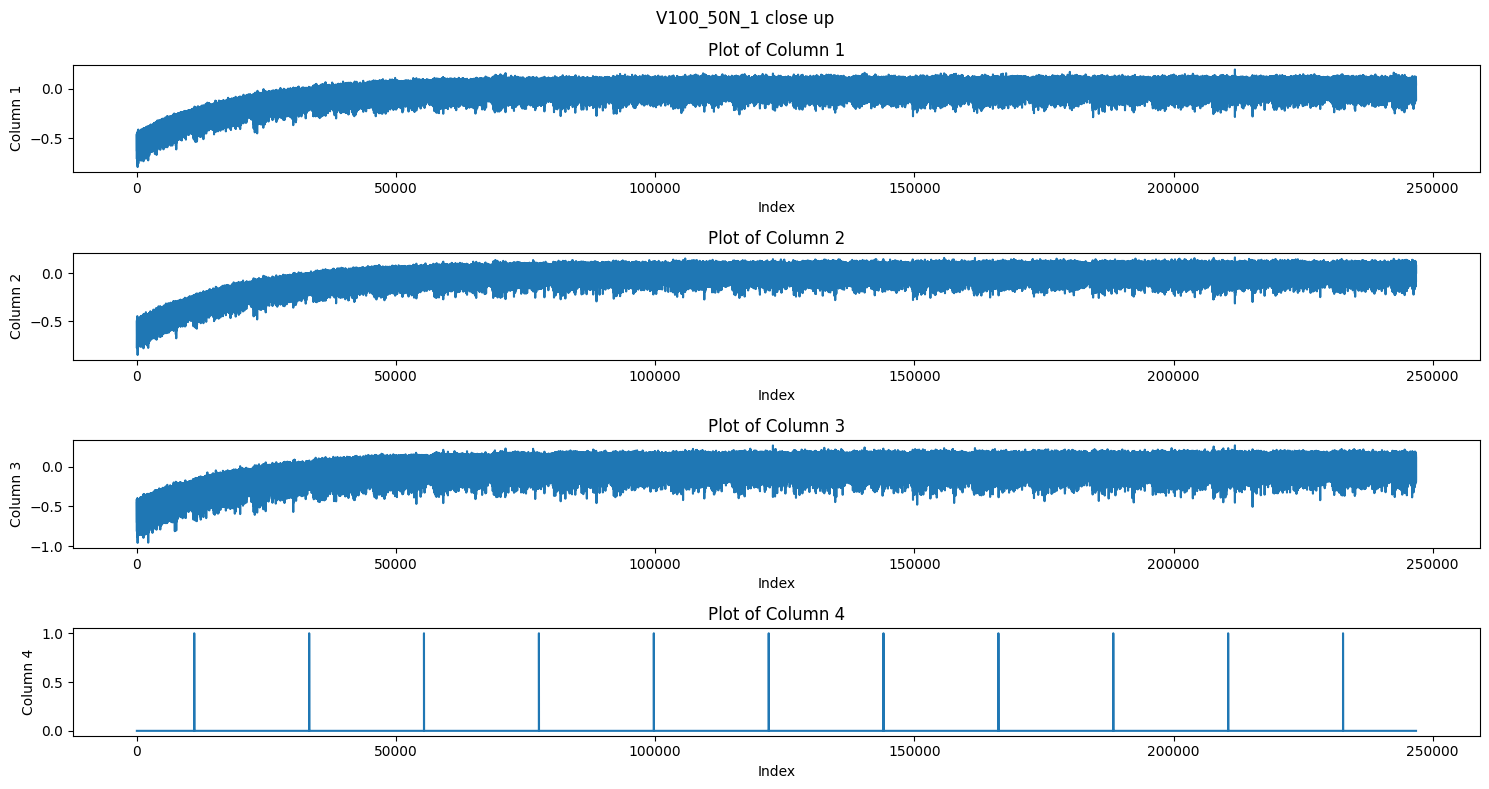

In [21]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V100_50N_1.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V100_50N_1.columns):
    axes[i].plot(df_V100_50N_1[column])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

plt.suptitle('V100_50N_1 close up')
plt.tight_layout()

# Display the plots
plt.show()

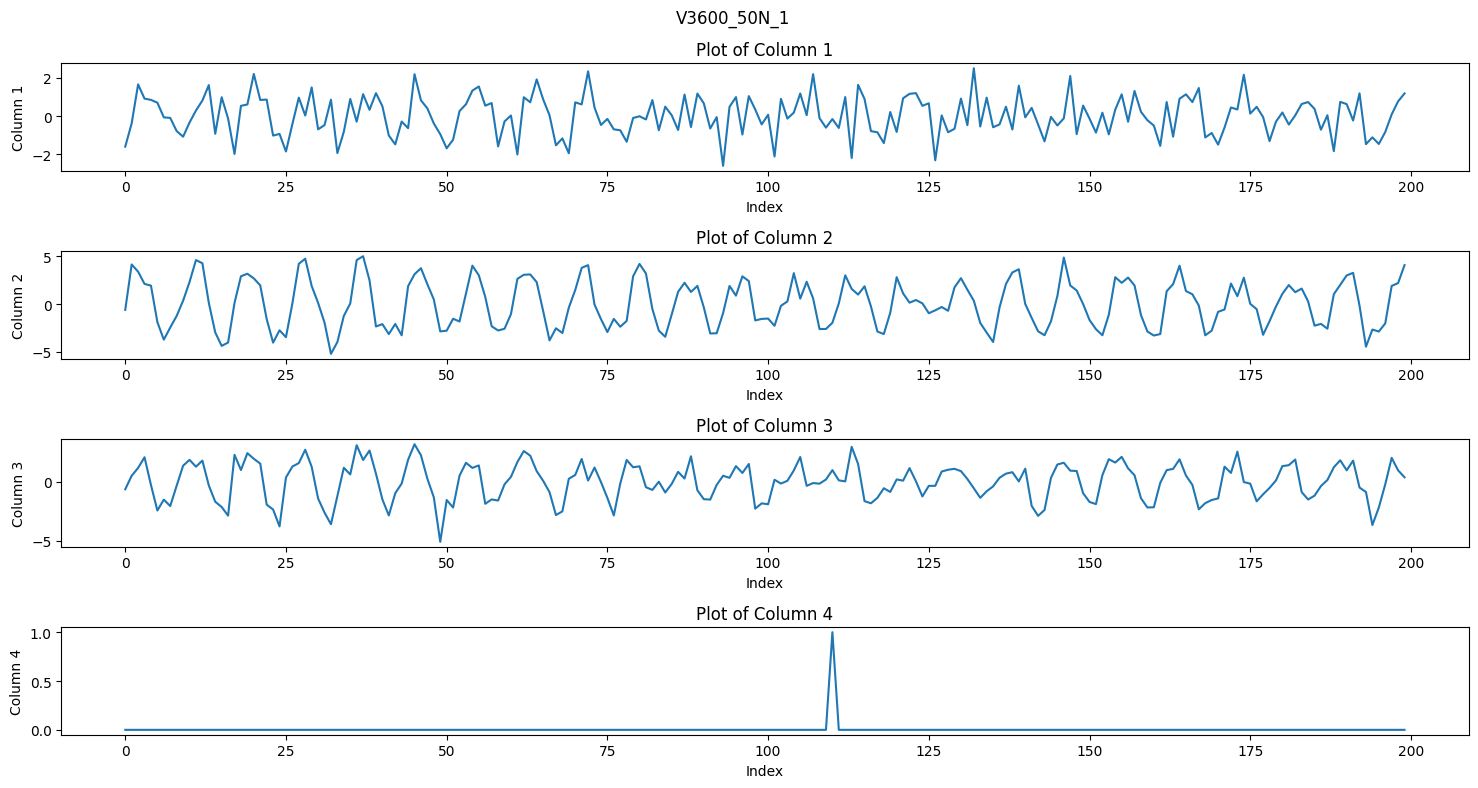

In [59]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V3600_50N_1.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V3600_50N_1.columns):
    axes[i].plot(df_V3600_50N_1[column].iloc[:200])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

plt.suptitle('V3600_50N_1 close up')
plt.tight_layout()

# Display the plots
plt.show()

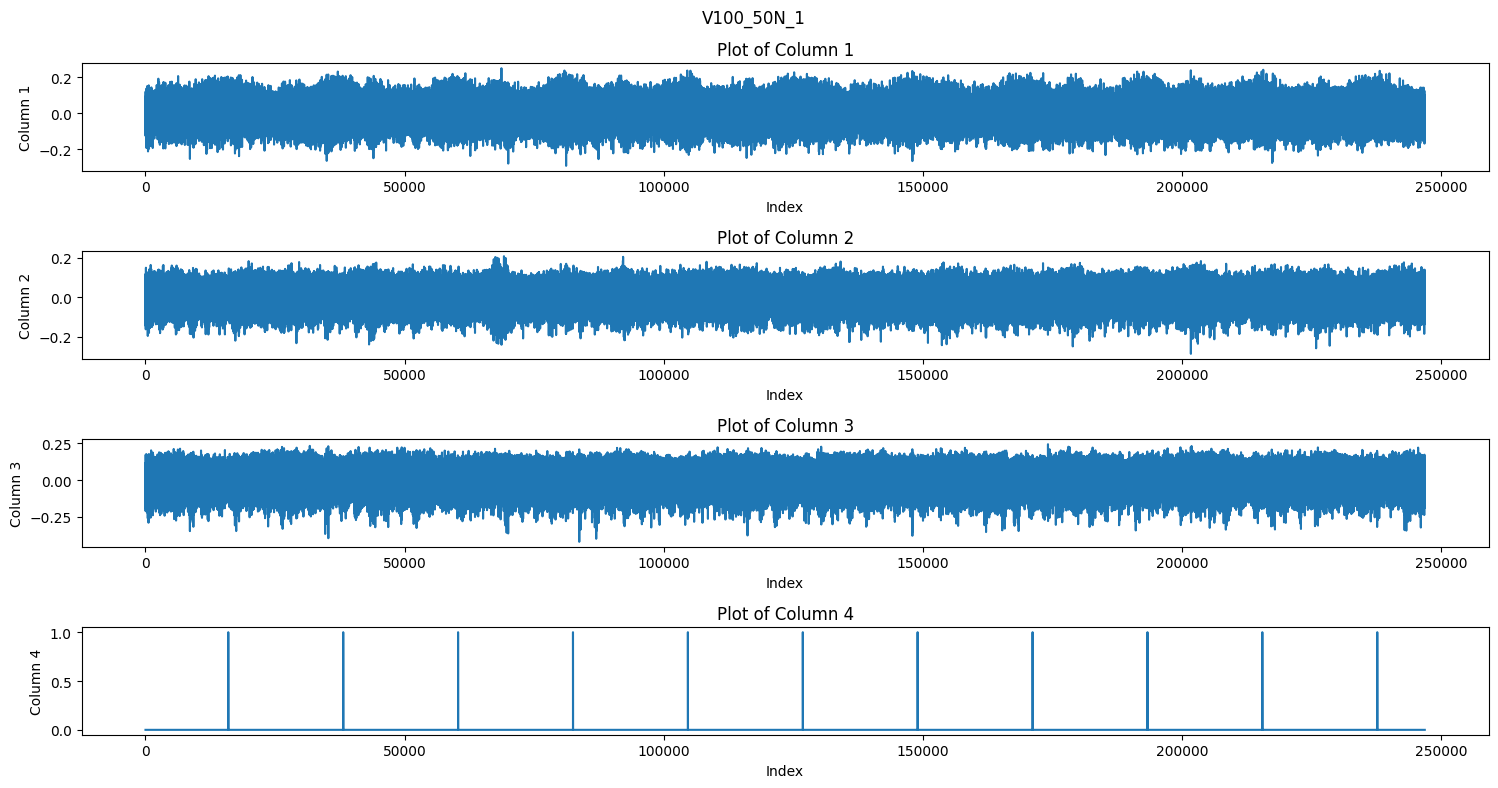

In [26]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V100_500N_1.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V100_500N_1.columns):
    axes[i].plot(df_V100_500N_1[column])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

plt.suptitle('V100_50N_1')
plt.tight_layout()

# Display the plots
plt.show()

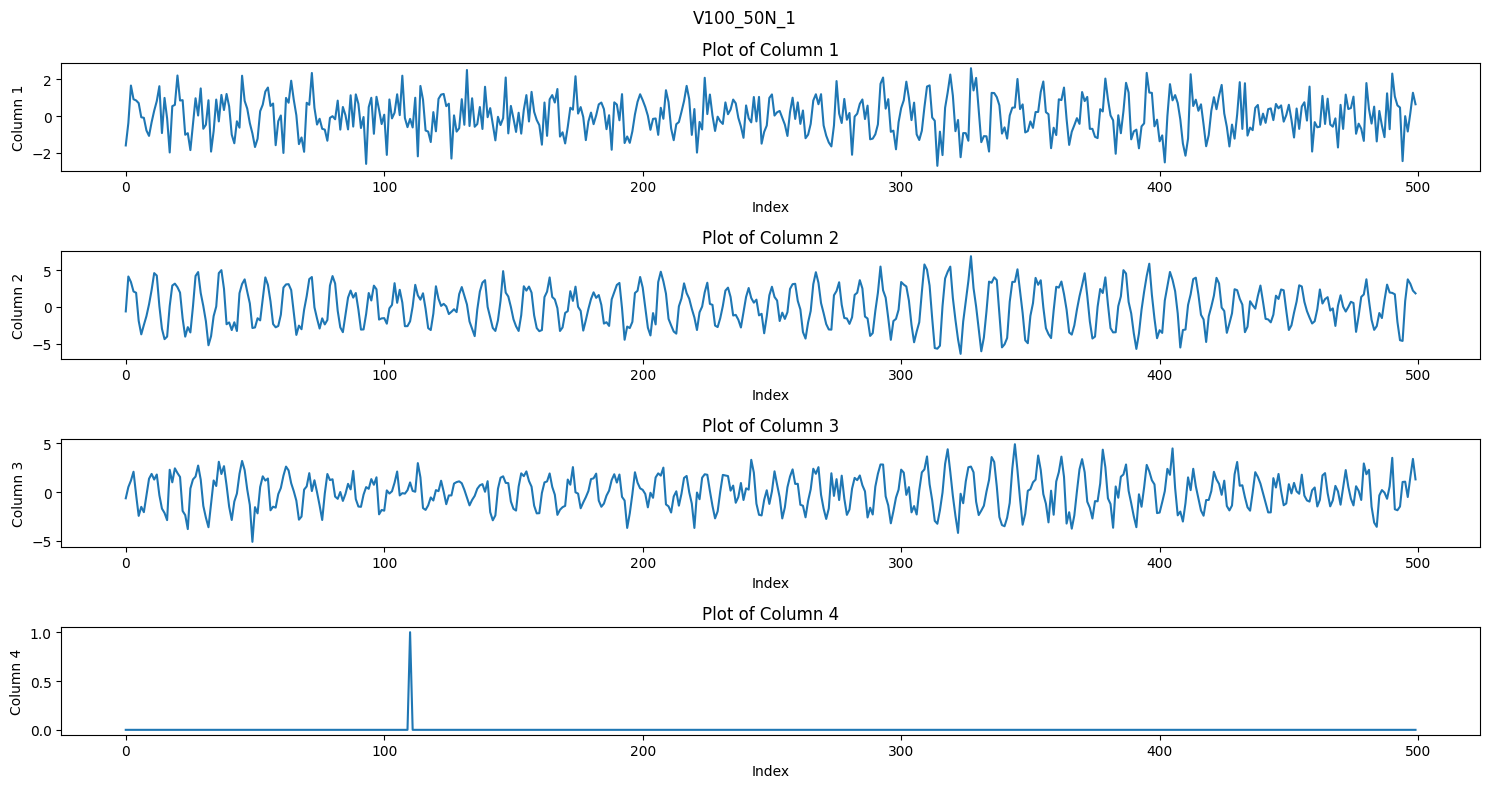

In [50]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V3600_50N_1.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V3600_50N_1.columns):
    axes[i].plot(df_V3600_50N_1[column].iloc[:500])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

plt.suptitle('V100_50N_1')
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V1200_500N_4.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V1200_500N_4.columns):
    axes[i].plot(df_V1200_500N_4[column])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

plt.suptitle('V100_50N_1')
plt.tight_layout()

# Display the plots
plt.show()
df_V1200_500N_4

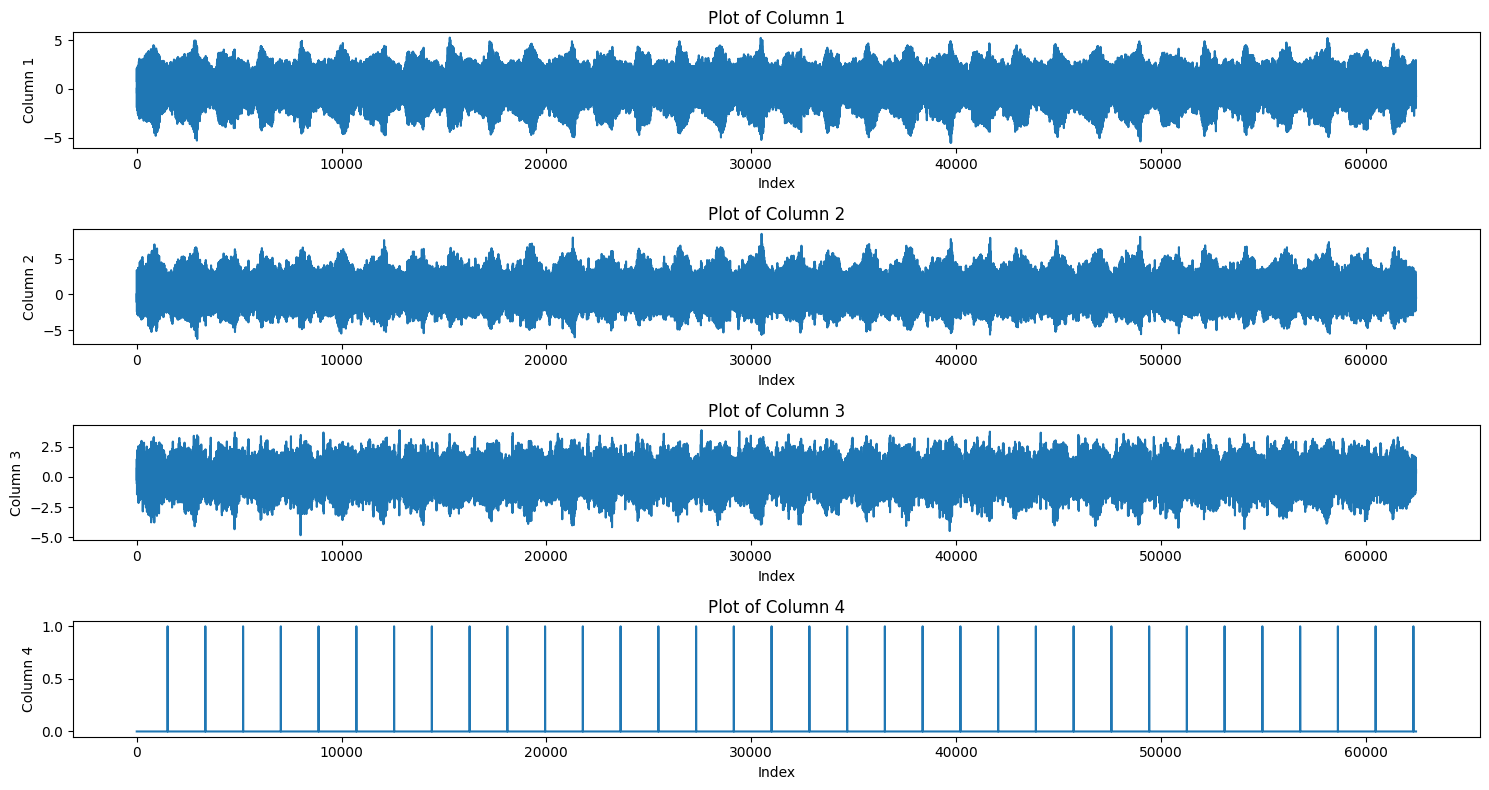

In [52]:
# Create a figure and axes with desired figsize
fig, axes = plt.subplots(nrows=len(df_V1200_500N_4.columns), figsize=(15, 8))

# Iterate over columns and plot on separate subplots
for i, column in enumerate(df_V1200_500N_4.columns):
    axes[i].plot(df_V1200_500N_4[column])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Column {i+1}')
    axes[i].set_title(f'Plot of Column {i+1}')

# Adjust the layout and spacing
plt.tight_layout()

# Display the plots
plt.show()

# Data Preperation

## test

## Load Data with split and one speed at a time

In [3]:
def from_2d_array_to_nested(X, index=None, columns=None, time_index=None, cells_as_numpy=False):
    """Convert 2D dataframe to nested dataframe.
    Convert tabular pandas DataFrame with only primitives in cells into
    nested pandas DataFrame with a single column.
    Parameters
    ----------
    X : pd.DataFrame
    cells_as_numpy : bool, default = False
        If True, then nested cells contain NumPy array
        If False, then nested cells contain pandas Series
    index : array-like, shape=[n_samples], optional (default = None)
        Sample (row) index of transformed DataFrame
    time_index : array-like, shape=[n_obs], optional (default = None)
        Time series index of transformed DataFrame
    Returns
    -------
    Xt : pd.DataFrame
        Transformed DataFrame in nested format
    """
    if (time_index is not None) and cells_as_numpy:
        raise ValueError(
            "`Time_index` cannot be specified when `return_arrays` is True, "
            "time index can only be set to "
            "pandas Series"
        )
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    container = np.array if cells_as_numpy else pd.Series

    # for 2d numpy array, rows represent instances, columns represent time points
    n_instances, n_timepoints = X.shape

    if time_index is None:
        time_index = np.arange(n_timepoints)
    kwargs = {"index": time_index}

    Xt = pd.DataFrame(
        pd.Series([container(X[i, :], **kwargs) for i in range(n_instances)])
    )
    if index is not None:
        Xt.index = index
    if columns is not None:
        Xt.columns = columns
    return Xt

def best_indices(coef, x=2000, twoD=True):

    # Create a boolean array of coefficients that are greater than or equal to 0.002

    abs_coef = np.abs(coef)

    sorted_indices = np.argsort(abs_coef)  
    if twoD == True:# indices of the x largest coefficients
    #top_x_indices = top_x_indices.iloc[0,-x:]
        topx=[]
        for i in np.arange(0,sorted_indices.shape[0]):
            top_x_indices = sorted_indices.reshape(-1)
            top_x_indices = top_x_indices[-x:]
            topx.append(top_x_indices)
        top_x_indices = np.concatenate(topx)
    else:
        top_x_indices = sorted_indices.reshape(-1)
        top_x_indices = top_x_indices[-x:]
    top_x_indices.sort()
    top_x_indices = np.unique(top_x_indices)
    return top_x_indices

def data_splitting(df_list, torque, speed,label, l=1):
    split_data = []
    torque_split = []
    speed_split = []
    label_split = []
    index_split = []
    counter=0
    for j, df in enumerate(df_list):
        counter += 1
        tmp = 0
        indices = np.where(np.array(df)[:, 3] == 1)
        if speed[j] in [100,300]:
            reset=l
        elif speed[j] in [200,400, 500, 600, 1200]:
            reset=l-1    
        elif speed[j] in [700, 800]:
            reset=l-2  
        elif speed[j] ==900:
            reset=l-3     
        else:
            reset=l-4    
        for i, index in enumerate(indices[0]):
            if tmp<l:
                tmp = tmp+1
            else:
                
                split_data.append(np.array(df.iloc[indices[0][i-l]:index, [0, 1, 2]]))
                torque_split.append(torque[j])
                speed_split.append(speed[j])
                label_split.append(label[j])
                index_split.append(counter)
                
                tmp=reset
    #split_data = np.concatenate(split_data, axis=2)  
    return split_data, speed_split, torque_split, label_split, index_split

def data_splitting_test(df_list, torque, speed, l=1):
    split_data = []
    torque_split = []
    speed_split = []
    label_split = []
    index_split = []
    counter=0
    for j, df in enumerate(df_list):
        counter += 1
        tmp = 0
        indices = np.where(np.array(df)[:, 3] == 1)
        if speed[j] in [100,300]:
            reset=l
        elif speed[j] in [200,400, 500, 600, 1200]:
            reset=l-1    
        elif speed[j] in [700, 800]:
            reset=l-2  
        elif speed[j] ==900:
            reset=l-3     
        else:
            reset=l-4    
        for i, index in enumerate(indices[0]):
            if tmp<l:
                tmp = tmp+1
            else:
                
                split_data.append(np.array(df.iloc[indices[0][i-l]:index, [0, 1, 2]]))
                torque_split.append(torque[j])
                speed_split.append(speed[j])

                index_split.append(counter)
                
                tmp=reset
    #split_data = np.concatenate(split_data, axis=2)  
    return split_data, speed_split, torque_split, index_split

def get_additional_features(split, torque, speed):
    additional_features = []
    for i,ts in enumerate(split):
        stats_df = []
        speed_torque_dict = {
        'speed_1': speed[i],
        'torque_1': torque[i]}
        speed_torque_df = pd.DataFrame.from_dict(speed_torque_dict, orient='index', columns=['Value'])
        for i in range(ts.shape[1]):

            mean = np.mean(ts[:,i])
            std_dev = np.std(ts[:,i])
            variance = np.var(ts[:,i])
            skewness = stats.skew(ts[:,i])
            kurtosis = stats.kurtosis(ts[:,i])
            autocorr = pd.Series(ts[:,i]).autocorr(lag=1)
            frequencies, density = signal.welch(ts[:,i], nperseg=256)
            density_df = pd.DataFrame(density.transpose()).transpose()
            outlier_list = []
            for j in [1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4, 4.25,4.5, 4.75, 5, 5.25,5.5,5.75,6]:
                threshold = j * std_dev
                nmb_outliers = np.sum(np.abs(ts[:,i] - mean) > threshold)
                outlier_list.append(nmb_outliers)
            outlier_df = pd.DataFrame([outlier_list])
            stats_dict = {
            'Mean': mean,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Auto-correlation (lag 1)': autocorr}
            stats_dict = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['0']).reset_index(drop=True).transpose()
            density_df = density_df.reset_index(drop=True)
            stats_dict.index = density_df.index
            outlier_df.index = density_df.index
            stats_df.append(pd.concat([stats_dict, density_df, outlier_df], axis=1))
        additional_features.append(np.concatenate([np.array(speed_torque_df.transpose()), np.concatenate(stats_df, axis=1)], axis=1))


    # Create a DataFrame from the dictionary
    #stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['Value'])
    return additional_features

def get_additional_features2(split, torque, speed):
    additional_features = []
    for i,ts in enumerate(split):
        stats_df = []

        speed_torque_dict = {
        'speed_1': speed[i],
        'torque_1': torque[i]}

        speed_torque_df = pd.DataFrame.from_dict(speed_torque_dict, orient='index', columns=['Value'])
        for i in range(ts.shape[1]):

            mean = np.mean(ts[i])
            std_dev = np.std(ts[i])
            variance = np.var(ts[i])
            skewness = stats.skew(ts[i])
            kurtosis = stats.kurtosis(ts[i])
            autocorr = pd.Series(ts[i]).autocorr(lag=1)
            frequencies, density = signal.welch(ts[i], nperseg=256)
            density_df = pd.DataFrame(density.transpose()).transpose()
            outlier_list = []
            for j in [1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4, 4.25,4.5, 4.75, 5, 5.25,5.5,5.75,6]:
                threshold = j * std_dev
                nmb_outliers = np.sum(np.abs(ts[i] - mean) > threshold)
                outlier_list.append(nmb_outliers)
            outlier_df = pd.DataFrame([outlier_list])
            stats_dict = {
            'Mean': mean,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Auto-correlation (lag 1)': autocorr}
            stats_dict = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['0']).reset_index(drop=True).transpose()
            density_df = density_df.reset_index(drop=True)
            stats_dict.index = density_df.index
            outlier_df.index = density_df.index
            stats_df.append(pd.concat([stats_dict, density_df, outlier_df], axis=1))
        additional_features.append(np.concatenate([np.array(speed_torque_df.transpose()), np.concatenate(stats_df, axis=1)], axis=1))


    # Create a DataFrame from the dictionary
    #stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['Value'])
    return additional_features
def interpolate_dataframes(array_list, l=1):
    target_length = 3687 * l
    new_list = []

    for i, arr in enumerate(array_list):
        arr_1 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_1 = arr_1(np.linspace(0,arr[:,0].size-1,target_length))
        arr_2 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_2 = arr_2(np.linspace(0,arr[:,0].size-1,target_length))
        arr_3 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_3 = arr_3(np.linspace(0,arr[:,0].size-1,target_length))
        interpolated_array = np.concatenate([arr_1.reshape(-1,1), arr_2.reshape(-1,1), arr_3.reshape(-1,1)], axis=1)
        new_list.append(interpolated_array)

    return new_list

def cut_dataframes(array_list, Drehzahl_list, l=1):
    
    new_list = []
    factor = 120/216
    for i, arr in enumerate(array_list):

        speed = Drehzahl_list[i]
        if speed in [100,200]:
            time=12
        elif speed in [300,400,500,600,700,800,900,1000]:
            time =6
        else:
            time=3         
        target_length = int((l/((speed/60) * factor)) * 20480)

        if len(arr)>=target_length:
            arr = arr[:target_length,:]
        else:
            zeros_to_append = target_length - len(arr)
            zeros_df = pd.DataFrame(0, index=range(zeros_to_append), columns=pd.DataFrame(arr).columns)
            arr = pd.concat([pd.DataFrame(arr), zeros_df])
        new_list.append(arr)

    return new_list

def cut_dataframes_all(array_list, Drehzahl_list):
    
    new_list = []
    factor = 120/216
    for i, arr in enumerate(array_list):

        speed = Drehzahl_list[i]
        if speed in [100,200]:
            time=12
        elif speed in [300,400,500,600,700,800,900,1000]:
            time =6
        else:
            time=3         
        l = math.floor((speed/60) * factor * time)
        target_length = int((l/((speed/60) * factor)) * 20480)
        
        if len(arr)>=target_length:
            arr = pd.DataFrame(np.array(arr)[:target_length,:])
        else:
            zeros_to_append = target_length - len(arr)
            zeros_df = pd.DataFrame(0, index=range(zeros_to_append), columns=pd.DataFrame(arr).columns)
            arr = pd.concat([arr, zeros_df])
        new_list.append(arr)

    return new_list

In [4]:
def data_splitting_test(df, torque, speed, l=1):
    split_data = []
    torque_split = []
    speed_split = []
    label_split = []
    index_split = []
    counter=0
    
    counter += 1
    tmp = 0

    indices = np.where(np.array(df)[:, 3] == 1)
    if speed in [100,300]:
        reset=l
    elif speed in [200,400, 500, 600, 1200]:
        reset=l-1    
    elif speed in [700, 800]:
        reset=l-2  
    elif speed ==900:
        reset=l-3     
    else:
        reset=l-4    
    for i, index in enumerate(indices[0]):
        if tmp<l:
            tmp = tmp+1
        else:
            
            split_data.append(np.array(df.iloc[indices[0][i-l]:index, [0, 1, 2]]))

            
            tmp=reset
    #split_data = np.concatenate(split_data, axis=2)  
    return split_data

In [5]:
def cut_dataframes(array_list, Drehzahl_list, l=1):
    
    new_list = []
    factor = 120/216
    for i, arr in enumerate(array_list):

        speed = Drehzahl_list
        if speed in [100,200]:
            time=12
        elif speed in [300,400,500,600,700,800,900,1000]:
            time =6
        else:
            time=3         
        target_length = int((l/((speed/60) * factor)) * 20480)

        if len(arr)>=target_length:
            arr = arr[:target_length,:]
        else:
            zeros_to_append = target_length - len(arr)
            zeros_df = pd.DataFrame(0, index=range(zeros_to_append), columns=pd.DataFrame(arr).columns)
            arr = pd.concat([pd.DataFrame(arr), zeros_df])
        new_list.append(arr)

    return new_list

In [6]:
def get_additional_features(split):
    additional_features = []
    for i,ts in enumerate(split):
        stats_df = []

        for i in range(ts.shape[1]):

            mean = np.mean(ts[:,i])
            std_dev = np.std(ts[:,i])
            variance = np.var(ts[:,i])
            skewness = stats.skew(ts[:,i])
            kurtosis = stats.kurtosis(ts[:,i])
            autocorr = pd.Series(ts[:,i]).autocorr(lag=1)
            frequencies, density = signal.welch(ts[:,i], nperseg=256)
            density_df = pd.DataFrame(density.transpose()).transpose()
            outlier_list = []
            for j in [1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4, 4.25,4.5, 4.75, 5, 5.25,5.5,5.75,6]:
                threshold = j * std_dev
                nmb_outliers = np.sum(np.abs(ts[:,i] - mean) > threshold)
                outlier_list.append(nmb_outliers)
            outlier_df = pd.DataFrame([outlier_list])
            stats_dict = {
            'Mean': mean,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Auto-correlation (lag 1)': autocorr}
            stats_dict = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['0']).reset_index(drop=True).transpose()
            density_df = density_df.reset_index(drop=True)
            stats_dict.index = density_df.index
            outlier_df.index = density_df.index
            stats_df.append(pd.concat([stats_dict, density_df, outlier_df], axis=1))
        additional_features.append(np.concatenate(stats_df, axis=1))


    # Create a DataFrame from the dictionary
    #stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['Value'])
    return additional_features

In [12]:
def interpolate_dataframes(array_list, l=1):
    target_length = 3687 * l
    new_list = []

    for i, arr in enumerate(array_list):
        arr_1 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_1 = arr_1(np.linspace(0,arr[:,0].size-1,target_length))
        arr_2 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_2 = arr_2(np.linspace(0,arr[:,0].size-1,target_length))
        arr_3 = interp.interp1d(np.arange(arr[:,0].size),arr[:,0])
        arr_3 = arr_3(np.linspace(0,arr[:,0].size-1,target_length))
        interpolated_array = np.concatenate([arr_1.reshape(-1,1), arr_2.reshape(-1,1), arr_3.reshape(-1,1)], axis=1)
        new_list.append(interpolated_array)

    return new_list

In [14]:
def transform_multi(path,file_name, label="test", save_path="C:\PHM_2023_Datadump\multi\Minirocket_1024_split"):
    if label == "test":
        speed_number = int(file_name.split("_")[1][1:])
        torque_number = int(file_name.split("_")[2][:-5])
        id_number = int(file_name.split("_")[0])
        file_name_new = f"test/{speed_number}_{torque_number}_{id_number}.csv"
    else:
        speed_number = int(file_name.split("_")[0][1:])
        torque_number = int(file_name.split("_")[1][:-1])
        id_number = int(file_name.split("_")[2][:-4])#
        file_name_new = f"{speed_number}_{torque_number}_{label}_{id_number}.csv"
    file_path = os.path.join(path, file_name)
    df = pd.read_csv(file_path, delimiter=' ', header = None)  
    split_data = data_splitting_test(df, torque_number, speed_number, l=5)
    additional_features = get_additional_features(split_data)    
    additional_features = pd.DataFrame(np.concatenate(additional_features))
    #additional_features.to_csv(f'C:/PHM_2023_Datadump/test_data/solo/test_additional/data_{k}_l5_add.csv', index=False)
    interpolated_ts = interpolate_dataframes(split_data, l=5)
    #interpolated_ts = cut_dataframes(split_data, speed_number, l=5)

    for j in np.arange(0,len(interpolated_ts)):
                df_2d = interpolated_ts[j].transpose()
                df_nested = from_2d_array_to_nested(df_2d)
                df1 = df_nested.transpose()
                if j==0:
                    df=df1
                else: 
                    df = pd.concat([df,df1], axis=0)

    df.reset_index(inplace=True, drop=True)

    
    mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")

    df_transformed = mrm.transform(df)
    num_rows = len(df_transformed)
    speed = np.full((num_rows,), speed_number)
    torque = np.full((num_rows,), torque_number)
    file_path = os.path.join(save_path, file_name_new)

    df_transformed = np.concatenate([pd.DataFrame(speed), pd.DataFrame(torque),pd.DataFrame(df_transformed),pd.DataFrame( additional_features)],axis=1 )
    #df_test.append(df_transformed)
    pd.DataFrame(df_transformed).to_csv(file_path, index=False)  

In [7]:
def transform(path,file_name, label="test", save_path="C:\PHM_2023_Datadump\solo\Minirocket_1024_split"):
    if label == "test":
        speed_number = int(file_name.split("_")[1][1:])
        torque_number = int(file_name.split("_")[2][:-5])
        id_number = int(file_name.split("_")[0])
        file_name_new = f"test/{speed_number}_{torque_number}_{id_number}.csv"
    else:
        speed_number = int(file_name.split("_")[0][1:])
        torque_number = int(file_name.split("_")[1][:-1])
        id_number = int(file_name.split("_")[2][:-4])
        file_name_new = f"V{speed_number}_/{torque_number}/{speed_number}_{torque_number}_{label}_{id_number}.csv"
    file_path = os.path.join(path, file_name)
    df = pd.read_csv(file_path, delimiter=' ', header = None)  
    split_data = data_splitting_test(df, torque_number, speed_number, l=5)
    additional_features = get_additional_features(split_data)    
    additional_features = pd.DataFrame(np.concatenate(additional_features))
    #additional_features.to_csv(f'C:/PHM_2023_Datadump/test_data/solo/test_additional/data_{k}_l5_add.csv', index=False)

    interpolated_ts = cut_dataframes(split_data, speed_number, l=5)

    for j in np.arange(0,len(interpolated_ts)):
                df_2d = interpolated_ts[j].transpose()
                df_nested = from_2d_array_to_nested(df_2d)
                df1 = df_nested.transpose()
                if j==0:
                    df=df1
                else: 
                    df = pd.concat([df,df1], axis=0)

    df.reset_index(inplace=True, drop=True)

    
    mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")

    df_transformed = mrm.transform(df)
    num_rows = len(df_transformed)
    speed = np.full((num_rows,), speed_number)
    torque = np.full((num_rows,), torque_number)
    file_path = os.path.join(save_path, file_name_new)

    df_transformed = np.concatenate([pd.DataFrame(speed), pd.DataFrame(torque),pd.DataFrame(df_transformed),pd.DataFrame( additional_features)],axis=1 )
    #df_test.append(df_transformed)
    pd.DataFrame(df_transformed).to_csv(file_path, index=False)    

In [18]:
save_path = "C:\PHM_2023_Datadump\multi\Minirocket_1024_split"
for i in [0,1,2,3,4,6,8]:
    file_path=f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"
    for speed in ["V1200_","V2100_","V2700_","V3000_","V3600_"]:
        for torque in [50,100,200,300,400,500]:
            for x,file_name in enumerate(os.listdir(file_path)):
                if file_name.endswith(".txt") and file_name.startswith(f"{speed}{torque}"):
                    transform_multi(file_path,file_name=file_name, label=i, save_path=save_path)

In [14]:
save_path = "C:\PHM_2023_Datadump\solo\Minirocket_1024_split"
for i in [0,1,2,3,4,6,8]:
    file_path=f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"
    for speed in ["V100_", "V200_","V300_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
        for torque in [50,100,200,300,400,500]:
            for x,file_name in enumerate(os.listdir(file_path)):
                if file_name.endswith(".txt") and file_name.startswith(f"{speed}{torque}"):
                    transform(file_path,file_name=file_name, label=i, save_path=save_path)

In [8]:
save_path = "C:\PHM_2023_Datadump\solo\Minirocket_1024_split"
file_path=f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_test_data"
for case in np.arange(1,801):
    case_us = f"{case}_"
    for x,file_name in enumerate(os.listdir(file_path)):
        if file_name.endswith(".txt") and file_name.startswith(f"{case_us}"):
            transform(file_path,file_name=file_name, save_path=save_path)

In [17]:
save_path = "C:\PHM_2023_Datadump\multi\Minirocket_1024_split"
file_path=f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_test_data"
allowed_strings = ["V1500_","V1800_","V2400_"]
for case in np.arange(1,801):
    case_us = f"{case}_"
    for x,file_name in enumerate(os.listdir(file_path)):
        if file_name.endswith(".txt") and file_name.startswith(f"{case_us}") and any(s in file_name for s in allowed_strings):
            transform_multi(file_path,file_name=file_name, save_path=save_path)

In [3]:
import numpy as np
test=np.array([2,1,5,6])
if not np.all(test[:2]):
    # If 0 or 1 is missing, add them to the front of the array
    test = np.concatenate((np.array([False, True]), test))

In [8]:
import numpy as np

test = np.array([2, 1, 5, 6])
if not np.all(test[:2] == [0, 1]):
    # If 0 or 1 is missing, add them to the front of the array
    test = np.insert(test, 0, [0, 1])

print(test)

[0 1 2 1 5 6]


In [13]:
import numpy as np

bool_coef = np.array([8,1, 4, 5, 6])
if not np.array_equal(bool_coef[:2], [0, 1]):
    # If either 0 or 1 is missing, add them to the front of the array
    bool_coef = np.concatenate(([0, 1], np.setdiff1d(bool_coef, [0, 1])))

print(test)

[0 1 4 5 6 8]


In [64]:

file_path=f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_test_data"
for x,file_name in enumerate(os.listdir(file_path)):
    if file_name.endswith(".txt") and "V1000_500" in file_name:
        transform(file_path,file_name=file_name)

In [76]:
path="C:/PHM_2023_Datadump/test"
dataframes = []
label=[]
for x,file_name in enumerate(os.listdir(path)):
    if file_name.endswith(".csv") and "test" not in file_name:
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        label_tmp = int(file_name.split("_")[2])     
        for _ in range(len(df)):
            label.append(label_tmp)
df = np.concatenate(dataframes)        

In [67]:
path="C:/PHM_2023_Datadump/test"
dataframes = []

for x,file_name in enumerate(os.listdir(path)):
    if file_name.endswith(".csv") and "test" in file_name:
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
 
df_test = np.concatenate(dataframes)  

In [77]:
df.shape

(275, 10460)

In [78]:
len(label)

275

In [79]:
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                        ('clf',  RidgeCV())])
multivar_rocket.fit(df, label)
y_pred = multivar_rocket.predict(df_test)


In [80]:
y_pred

array([3.01098422, 2.86439442, 3.06860323, 3.04652492, 3.05466773,
       2.9672269 , 2.89662853, 2.88701878, 2.85804686, 2.93500731,
       3.05310544, 1.96375448, 2.15156111, 1.94296233, 1.98159758,
       2.03359297, 1.98567258, 2.01305695, 1.89249675, 2.11532152,
       1.95109661, 2.05683874, 3.94038501, 3.90608241, 3.94236485,
       3.89009256, 3.90300908, 3.82265085, 3.81583977, 3.83210939,
       3.91065346, 3.86206238, 3.81512681, 8.15563975, 8.16321195,
       8.04987319, 8.00712375, 8.18977826, 7.89738935, 7.79542833,
       7.97028112, 7.97602386, 8.00562143, 8.00332217, 4.57530854,
       4.54209794, 4.56393146, 4.74350412, 4.39640961, 4.34543773,
       4.42586343, 4.63169054, 4.72405862, 4.73792796, 4.63033225])

In [11]:
from sktime.datasets import write_dataframe_to_tsfile
for i in [0]:
    print(i)
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"
    if i ==10:
        for k in np.arange(1,2):
            n=f"{k}_"
            train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_test_data"

            dataframes = []
            torque = []
            speed = []

            for x,file_name in enumerate(os.listdir(train_path)):
                if file_name.endswith(".txt") and file_name.startswith(f"{n}"):
                    file_path = os.path.join(train_path, file_name)
                    print(file_path)
                    with open(file_path, "r") as file:
                        content = file.read()

                            # Extract numbers from the file name

                    speed_number = int(file_name.split("_")[1][1:])
                    torque_number = int(file_name.split("_")[2][:-5])
                    print(speed_number)
                    # Save the numbers
                    speed.append(speed_number)
                    torque.append(torque_number)
                    
                    df = pd.read_csv(file_path, delimiter=' ', header = None)
                    dataframes.append(df)

            split_data, speed_split, torque_split, index_split = data_splitting_test(dataframes, torque, speed, l=5)
            
            additional_features = get_additional_features(split_data, speed_split, torque_split)    
            additional_features = pd.DataFrame(np.concatenate(additional_features))
            additional_features.to_csv(f'C:/PHM_2023_Datadump/test_data/solo/test_additional/data_{k}_l5_add.csv', index=False)
            print(additional_features)
            interpolated_ts = cut_dataframes(split_data, speed_split, l=5)

            mrm_model = joblib.load('mini_model_1024.pkl')
            save_path =f"C:/PHM_2023_Datadump/test_data/solo/Minirocket_1024/"
            # Iterate over the list of dataframes

            for j in np.arange(0,len(interpolated_ts)):
                df_2d = interpolated_ts[j].transpose()
                df_nested = from_2d_array_to_nested(df_2d)
                df1 = df_nested.transpose()
                if j==0:
                    df=df1
                else: 
                    df = pd.concat([df,df1], axis=0)
            df.reset_index(inplace=True, drop=True)
            if os.path.exists("C:/PHM_2023_Datadump/mini_rocket_1024"):
                # Load the model from file
                mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")

                df_transformed = mrm.transform(df)
            else:
                #mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
                print(error)
                df_transformed = mrm.fit_transform(df)
                joblib.dump(mrm, "C:/PHM_2023_Datadump/mini_rocket_1024")
            # Create the file name based on the values

            file_name = f"data_{k}_{speed_number}.csv"
            file_path = os.path.join(save_path, file_name)
            print(df_transformed)
            df_transformed = np.concatenate([pd.DataFrame(df_transformed), pd.DataFrame(speed_split), pd.DataFrame(torque_split)],axis=1 )
            #df_test.append(df_transformed)
            pd.DataFrame(df_transformed).to_csv(file_path, index=False)

    else:
    #for d in ["V300_", "V3000_"]:
        for d in ["V100_", "V200_","V300_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
        #for d in ["V2100_","V2700_","V3000_","V3600_"]:
            dataframes = []
            torque = []
            speed = []
            label = []
            for x,file_name in enumerate(os.listdir(train_path)):
                if file_name.endswith(".txt") and d in file_name:
                    file_path = os.path.join(train_path, file_name)

                    with open(file_path, "r") as file:
                        content = file.read()

                            # Extract numbers from the file name

                    speed_number = int(file_name.split("_")[0][1:])
                    torque_number = int(file_name.split("_")[1][:-1])

                    # Save the numbers
                    speed.append(speed_number)
                    torque.append(torque_number)
                    label.append(i)
                    
                    df = pd.read_csv(file_path, delimiter=' ', header = None)
                    dataframes.append(df)

            split_data, speed_split, torque_split, label_split, index_split = data_splitting(dataframes, torque, speed, label, l=5)   
            print(speed)
            print(speed_split)
            print(index_split)
            additional_features = get_additional_features(split_data, speed_split, torque_split)    
            additional_features = pd.DataFrame(np.concatenate(additional_features))
            additional_features.to_csv(f'C:/PHM_2023_Datadump/solo/train_additional_split/{d}/data_{i}_l5_add.csv', index=False)
            print(additional_features)  
            interpolated_ts = cut_dataframes(split_data,speed_split,  l=5)

            mrm_model = joblib.load('mini_model_1024.pkl')
            save_path =f"C:/PHM_2023_Datadump/solo/Minirocket_1024_split/{d}"
            # Iterate over the list of dataframes

            for j in np.arange(0,len(interpolated_ts)):
                df_2d = interpolated_ts[j].transpose()
                df_nested = from_2d_array_to_nested(df_2d)
                df1 = df_nested.transpose()
                if j==0:
                    df=df1
                else: 
                    df = pd.concat([df,df1], axis=0)
            df.reset_index(inplace=True, drop=True)
            if os.path.exists("C:/PHM_2023_Datadump/mini_rocket_1024"):
                # Load the model from file
                mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")
                df_transformed = mrm_model.transform(df)
            else:
                mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
                df_transformed = mrm.fit_transform(df)
                joblib.dump(mrm, "C:/PHM_2023_Datadump/mini_rocket_1024")
            # Create the file name based on the values
            file_name = f"data_{i}.csv"
            file_path = os.path.join(save_path, file_name)
            print(df_transformed)
            df_transformed = np.concatenate([pd.DataFrame(df_transformed), pd.DataFrame(speed_split), pd.DataFrame(torque_split), pd.DataFrame(label_split), pd.DataFrame(index_split)],axis=1 )

            pd.DataFrame(df_transformed).to_csv(file_path, index=False)

0
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,

In [ ]:
from sktime.datasets import write_dataframe_to_tsfile
df_test =[]
for i in np.arange(1,801):
    print(i)
    n=f"{i}_"
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_test_data"

    dataframes = []
    torque = []
    speed = []

    for x,file_name in enumerate(os.listdir(train_path)):
        if file_name.endswith(".txt") and file_name.startswith(f"{n}"):
            file_path = os.path.join(train_path, file_name)

            with open(file_path, "r") as file:
                content = file.read()

                    # Extract numbers from the file name

            speed_number = int(file_name.split("_")[1][1:])
            torque_number = int(file_name.split("_")[2][:-5])
            print(speed_number)
            # Save the numbers
            speed.append(speed_number)
            torque.append(torque_number)
            
            df = pd.read_csv(file_path, delimiter=' ', header = None)
            dataframes.append(df)

    split_data, speed_split, torque_split = data_splitting(dataframes, torque, speed, l=5)    
    additional_features = get_additional_features(split_data, speed_split, torque_split)    
    additional_features = pd.DataFrame(np.concatenate(additional_features))
    additional_features.to_csv(f'C:/PHM_2023_Datadump/test_data/solo/test_additional/data_{i}_l5_add.csv', index=False)

    interpolated_ts = cut_dataframes(split_data, speed_split, l=5)

    mrm_model = joblib.load('mini_model_1024.pkl')
    save_path =f"C:/PHM_2023_Datadump/test_data/solo/Minirocket_1024/"
    # Iterate over the list of dataframes

    for j in np.arange(0,len(interpolated_ts)):
        df_2d = interpolated_ts[j].transpose()
        df_nested = from_2d_array_to_nested(df_2d)
        df1 = df_nested.transpose()
        if j==0:
            df=df1
        else: 
            df = pd.concat([df,df1], axis=0)
    df.reset_index(inplace=True, drop=True)
    if os.path.exists("C:/PHM_2023_Datadump/mini_rocket_1024"):
        # Load the model from file
        mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")

        df_transformed = mrm.transform(df)
    else:
        mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
        df_transformed = mrm.fit_transform(df)
        joblib.dump(mrm, "C:/PHM_2023_Datadump/mini_rocket_1024")
    # Create the file name based on the values
    file_name = f"data_{i}_{speed_number}.csv"
    file_path = os.path.join(save_path, file_name)

    df_transformed = np.concatenate([pd.DataFrame(df_transformed), pd.DataFrame(speed_split), pd.DataFrame(torque_split)],axis=1 )
    #df_test.append(df_transformed)
    pd.DataFrame(df_transformed).to_csv(file_path, index=False)

## Load Data without split and one speed at a time

In [5]:
from sktime.datasets import write_dataframe_to_tsfile
for i in [0,1,2,3,4,6,8]:
    print(i)
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"


    #for d in ["V300_", "V3000_"]:
    for d in ["V100_", "V200_","V300_","V400_","V500_","V600_","V700_","V800_","V900_","V1000_","V1200_","V2100_","V2700_","V3000_","V3600_"]:
        dataframes = []
        torque = []
        speed = []
        label = []
        for x,file_name in enumerate(os.listdir(train_path)):
            if file_name.endswith(".txt") and d in file_name:
                file_path = os.path.join(train_path, file_name)

                with open(file_path, "r") as file:
                    content = file.read()

                        # Extract numbers from the file name

                speed_number = int(file_name.split("_")[0][1:])
                torque_number = int(file_name.split("_")[1][:-1])

                # Save the numbers
                speed.append(speed_number)
                torque.append(torque_number)
                label.append(i)
                
                df = pd.read_csv(file_path, delimiter=' ', header = None)
                dataframes.append(df)

        #split_data, speed_split, torque_split, label_split = data_splitting(dataframes, torque, speed, label, l=5)    
        additional_features = get_additional_features2(dataframes, speed, torque)    
        additional_features = pd.DataFrame(np.concatenate(additional_features))
        additional_features.to_csv(f'C:/PHM_2023_Datadump/solo/train_additional/{d}/data_{i}_add.csv', index=False)

        interpolated_ts = cut_dataframes_all(dataframes, speed)

        mrm_model = joblib.load('mini_model_1024.pkl')
        save_path =f"C:/PHM_2023_Datadump/solo/Minirocket_1024/{d}"
        # Iterate over the list of dataframes

        for j in np.arange(0,len(interpolated_ts)):
            df_2d = interpolated_ts[j].transpose()
            df_nested = from_2d_array_to_nested(df_2d)
            df1 = df_nested.transpose()
            if j==0:
                df=df1
            else: 
                df = pd.concat([df,df1], axis=0)
        df.reset_index(inplace=True, drop=True)
        if os.path.exists("C:/PHM_2023_Datadump/mini_rocket_1024"):
            # Load the model from file
            mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")
            df_transformed = mrm_model.transform(df)
        else:
            mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
            df_transformed = mrm.fit_transform(df)
            joblib.dump(mrm, "C:/PHM_2023_Datadump/mini_rocket_1024")
        # Create the file name based on the values
        file_name = f"data_{i}.csv"
        file_path = os.path.join(save_path, file_name)

        df_transformed = np.concatenate([pd.DataFrame(df_transformed), pd.DataFrame(speed), pd.DataFrame(torque), pd.DataFrame(label)],axis=1 )

        pd.DataFrame(df_transformed).to_csv(file_path, index=False)

0
1
2
3
4
6
8


## Load Data with split and high speed

In [6]:
from sktime.datasets import write_dataframe_to_tsfile
for i in [0,1,2,3,4,6,8]:
    print(i)
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"


    #for d in ["V300_", "V3000_"]:
    for d in ["V1200_","V2100_","V2700_","V3000_","V3600_"]:
        dataframes = []
        torque = []
        speed = []
        label = []
        for x,file_name in enumerate(os.listdir(train_path)):
            if file_name.endswith(".txt") and d in file_name:
                file_path = os.path.join(train_path, file_name)

                with open(file_path, "r") as file:
                    content = file.read()

                        # Extract numbers from the file name

                speed_number = int(file_name.split("_")[0][1:])
                torque_number = int(file_name.split("_")[1][:-1])

                # Save the numbers
                speed.append(speed_number)
                torque.append(torque_number)
                label.append(i)
                
                df = pd.read_csv(file_path, delimiter=' ', header = None)
                dataframes.append(df)

        split_data, speed_split, torque_split, label_split, index_split = data_splitting(dataframes, torque, speed, label, l=5)    
        additional_features = get_additional_features(split_data, speed_split, torque_split)    
        additional_features = pd.DataFrame(np.concatenate(additional_features))
        additional_features.to_csv(f'C:/PHM_2023_Datadump/multi/train_additional_split/data_{i}_{d}l5_add.csv', index=False)

        interpolated_ts = interpolate_dataframes(split_data, l=5)

        mrm_model = joblib.load('mini_model_1024.pkl')
        save_path =f"C:/PHM_2023_Datadump/multi/Minirocket_1024_split"
        # Iterate over the list of dataframes

        for j in np.arange(0,len(interpolated_ts)):
            df_2d = interpolated_ts[j].transpose()
            df_nested = from_2d_array_to_nested(df_2d)
            df1 = df_nested.transpose()
            if j==0:
                df=df1
            else: 
                df = pd.concat([df,df1], axis=0)
        df.reset_index(inplace=True, drop=True)
        if os.path.exists("C:/PHM_2023_Datadump/mini_rocket_1024"):
            # Load the model from file
            mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")
            df_transformed = mrm_model.transform(df)
        else:
            mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
            df_transformed = mrm.fit_transform(df)
            joblib.dump(mrm, "C:/PHM_2023_Datadump/mini_rocket_1024")
        # Create the file name based on the values
        file_name = f"data_{i}_{d}.csv"
        file_path = os.path.join(save_path, file_name)

        df_transformed = np.concatenate([pd.DataFrame(df_transformed), pd.DataFrame(speed_split), pd.DataFrame(torque_split), pd.DataFrame(label_split), pd.DataFrame(index_split)],axis=1 )

        pd.DataFrame(df_transformed).to_csv(file_path, index=False)

0
1
2
3
4
6
8


In [10]:
from sktime.datasets import write_dataframe_to_tsfile
for i in [0,1,2,3,4,6,8]:
    print(i)
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"


    for d in ["V3000_", "V3600_"]:
        length = len(os.listdir(train_path))
        indices = list(range(0, length + 1, 10))
        indices.append(length)
        for y,index in enumerate(indices):
            dataframes = []
            torque = []
            speed = []
            label = []
            if index == indices[-1]:
                break
            for x,file_name in enumerate(os.listdir(train_path)[index:indices[y+1]]):
                if file_name.endswith(".txt") and d in file_name:
                    file_path = os.path.join(train_path, file_name)
                    print(filename)
                    with open(file_path, "r") as file:
                        content = file.read()

                            # Extract numbers from the file name

                    speed_number = int(file_name.split("_")[0][1:])
                    torque_number = int(file_name.split("_")[1][:-1])
                    
                    # Save the numbers
                    speed.append(speed_number)
                    torque.append(torque_number)
                    label.append(i)
                    
                    df = pd.read_csv(file_path, delimiter=' ', header = None)
                    dataframes.append(df)

            split_data, speed_split, torque_split, label_split = data_splitting(dataframes, torque, speed, label, l=5)    
            print(dataframes)
            additional_features = get_additional_features(split_data, speed_split, torque_split)    
            additional_features = pd.DataFrame(np.concatenate(additional_features))
            additional_features.to_csv(f'C:/PHM_2023_Datadump/solo/train_additional/{d}/data_{i}_{y}_l5_add.csv', index=False)

            interpolated_ts = cut_dataframes(split_data, speed, l=5)

            mrm_model = joblib.load('mini_model_1024.pkl')
            save_path =f"C:/PHM_2023_Datadump/solo/Minirocket_1024/{d}"
            # Iterate over the list of dataframes
            print("save csv files")
            for j in np.arange(0,len(interpolated_ts)):
                df_2d = interpolated_ts[j].transpose()
                df_nested = from_2d_array_to_nested(df_2d)
                df1 = df_nested.transpose()
                if j==0:
                    df=df1
                else: 
                    df = pd.concat([df,df1], axis=0)
            df.reset_index(inplace=True, drop=True)
            if os.path.exists("C:/PHM_2023_Datadump/mini_rocket_1024"):
                # Load the model from file
                mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")
                df_transformed = mrm_model.transform(df)
            else:
                mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
                df_transformed = mrm.fit_transform(df)
                joblib.dump(mrm, "C:/PHM_2023_Datadump/mini_rocket_1024")
            # Create the file name based on the values
            file_name = f"data_{i}_{y}.csv"
            file_path = os.path.join(save_path, file_name)

            df_transformed = np.concatenate([pd.DataFrame(df_transformed), pd.DataFrame(speed_split), pd.DataFrame(torque_split), pd.DataFrame(label_split)],axis=1 )

            pd.DataFrame(df_transformed).to_csv(file_path, index=False)

0
[]


ValueError: need at least one array to concatenate

In [6]:
from sktime.datasets import write_dataframe_to_tsfile
for i in [0,1,2,3,4,6,8]:
    print(i)
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"

    length = len(os.listdir(train_path))
    indices = list(range(0, length + 1, 10))
    indices.append(length)
    for y,index in enumerate(indices):
        dataframes = []
        torque = []
        speed = []
        label = []
        if index == indices[-1]:
            break
        for x,file_name in enumerate(os.listdir(train_path)[index:indices[y+1]]):
            if file_name.endswith(".txt"):
                file_path = os.path.join(train_path, file_name)
                
                with open(file_path, "r") as file:
                    content = file.read()

                        # Extract numbers from the file name

                speed_number = int(file_name.split("_")[0][1:])
                torque_number = int(file_name.split("_")[1][:-1])
                
                # Save the numbers
                speed.append(speed_number)
                torque.append(torque_number)
                label.append(i)
                
                df = pd.read_csv(file_path, delimiter=' ', header = None)
                dataframes.append(df)

        split_data, speed_split, torque_split, label_split = data_splitting(dataframes, torque, speed, label, l=5)    

        additional_features = get_additional_features(split_data, speed_split, torque_split)    
        additional_features = pd.DataFrame(np.concatenate(additional_features))
        additional_features.to_csv(f'C:/PHM_2023_Datadump/train_additional/data_{i}_{y}_l5_add.csv', index=False)

        interpolated_ts = interpolate_dataframes(split_data, l=5)

        mrm_model = joblib.load('mini_model_1024.pkl')
        save_path ="C:/PHM_2023_Datadump/Minirocket_1024"
        # Iterate over the list of dataframes
        print("save csv files")
        for j in np.arange(0,len(interpolated_ts)):
            df_2d = interpolated_ts[j].transpose()
            df_nested = from_2d_array_to_nested(df_2d)
            df1 = df_nested.transpose()
            if j==0:
                df=df1
            else: 
                df = pd.concat([df,df1], axis=0)
        df.reset_index(inplace=True, drop=True)
        if os.path.exists("C:/PHM_2023_Datadump/mini_rocket_1024"):
            # Load the model from file
            mrm = joblib.load("C:/PHM_2023_Datadump/mini_rocket_1024")
            df_transformed = mrm_model.transform(df)
        else:
            mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
            df_transformed = mrm.fit_transform(df)
            joblib.dump(mrm, "C:/PHM_2023_Datadump/mini_rocket_1024")
        # Create the file name based on the values
        file_name = f"data_{i}_{y}.csv"
        file_path = os.path.join(save_path, file_name)

        df_transformed = np.concatenate([pd.DataFrame(df_transformed), pd.DataFrame(speed_split), pd.DataFrame(torque_split), pd.DataFrame(label_split)],axis=1 )

        pd.DataFrame(df_transformed).to_csv(file_path, index=False)



0
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
1
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
2
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save csv files
save

In [ ]:
from sktime.datasets import write_dataframe_to_tsfile
for i in [0,1,2,3,4,6,8]:
    print(i)
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"
    dataframes = []
    torque = []
    speed = []
    label = []
    length = len(os.listdir(train_path))
    indices = list(range(0, length + 1, 10))
    indices.append(length)
    for y,index in enumerate(indices):
        if index == indices[-1]:
            break
        for file_name in os.listdir(train_path)[index:indices[y+1]]:
            if file_name.endswith(".txt"):
                file_path = os.path.join(train_path, file_name)
                
                with open(file_path, "r") as file:
                    content = file.read()

                        # Extract numbers from the file name
                speed_number = int(file_name.split("_")[0][1:])
                torque_number = int(file_name.split("_")[1][:-1])
                
                # Save the numbers
                speed.append(speed_number)
                torque.append(torque_number)
                label.append(i)
                
                df = pd.read_csv(file_path, delimiter=' ', header = None)
                dataframes.append(df)
    split_data, speed_split, torque_split, label_split = data_splitting(dataframes, torque, speed, label, l=5)    
    del df
    del dataframes
    additional_features = get_additional_features(split_data, speed_split, torque_split)    
    additional_features = pd.DataFrame(np.concatenate(additional_features))
    additional_features.to_csv(f'C:/PHM_2023_Datadump/train_additional/data_class{i}_l5_add.csv', index=False)
    del additional_features
    interpolated_ts = interpolate_dataframes(split_data, l=5)
    del split_data
    mrm_model = joblib.load('mini_model_1024.pkl')

    train_path ="C:/PHM_2023_Datadump/train_interpolated"
    # Iterate over the list of dataframes
    print("save csv files")
    for j, df in enumerate(interpolated_ts):
        # Get the values for torque_split, speed_split, and clss at position i
        torque_tmp = torque_split[j]
        speed_tmp = speed_split[j]
        class_tmp = i
        df = mrm_model.transform(df)
        # Create the file name based on the values
        file_name = f"data_{speed_tmp}_{torque_tmp}_{class_tmp}_{j}.csv"
        file_path = os.path.join(train_path, file_name)
        # Save the dataframe as a CSV file
        pd.DataFrame(df).to_csv(file_path, index=False)
    

    del interpolated_ts

In [9]:
from sktime.datasets import write_dataframe_to_tsfile
for i in [0,1,2,3,4,6,8]:
    print(i)
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"
    dataframes = []
    torque = []
    speed = []
    label = []
    for file_name in os.listdir(train_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(train_path, file_name)
            
            with open(file_path, "r") as file:
                content = file.read()

                    # Extract numbers from the file name
            speed_number = int(file_name.split("_")[0][1:])
            torque_number = int(file_name.split("_")[1][:-1])
            
            # Save the numbers
            speed.append(speed_number)
            torque.append(torque_number)
            label.append(i)
            
            df = pd.read_csv(file_path, delimiter=' ', header = None)
            dataframes.append(df)
    split_data, speed_split, torque_split, label_split = data_splitting(dataframes, torque, speed, label, l=5)    
    del df
    del dataframes
    additional_features = get_additional_features(split_data, speed_split, torque_split)    
    additional_features = pd.DataFrame(np.concatenate(additional_features))
    additional_features.to_csv(f'C:/PHM_2023_Datadump/train_additional/data_class{i}_l5_add.csv', index=False)
    del additional_features
    interpolated_ts = interpolate_dataframes(split_data, l=5)
    del split_data
    train_path ="C:/PHM_2023_Datadump/traininterpolated"
    # Iterate over the list of dataframes
    print("save csv files")
    for j, df in enumerate(interpolated_ts):
        # Get the values for torque_split, speed_split, and clss at position i
        torque_tmp = torque_split[j]
        speed_tmp = speed_split[j]
        class_tmp = i

        # Create the file name based on the values
        file_name = f"data_{speed_tmp}_{torque_tmp}_{class_tmp}_{j}.csv"
        file_path = os.path.join(train_path, file_name)
        # Save the dataframe as a CSV file
        pd.DataFrame(df).to_csv(file_path, index=False)
    

    del interpolated_ts

0
save csv files
1


KeyboardInterrupt: 

In [6]:
import os
import numpy as np
import pandas as pd
from sktime.datasets import write_dataframe_to_tsfile

def process_data(train_path):
    dataframes = []
    torque = []
    speed = []
    label = []
    
    for file_name in os.listdir(train_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(train_path, file_name)
            
            with open(file_path, "r") as file:
                content = file.read()

            # Extract numbers from the file name
            speed_number = int(file_name.split("_")[0][1:])
            torque_number = int(file_name.split("_")[1][:-1])
            
            # Save the numbers
            speed.append(speed_number)
            torque.append(torque_number)
            label.append(i)
            
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            dataframes.append(df)

    split_data, speed_split, torque_split, label_split = data_splitting(dataframes, torque, speed, label, l=5)
    
    additional_features = get_additional_features(split_data, speed_split, torque_split)
    additional_features = pd.DataFrame(np.concatenate(additional_features))
    additional_features.to_csv(f'C:/PHM_2023_Datadump/train_additional/data_class{i}_l5_add.csv', index=False)

    interpolated_dataframes = []
    for df in split_data:
        interpolated_df = interpolate_dataframes(df, l=5)
        interpolated_dataframes.append(interpolated_df)

    df_high = pd.concat(interpolated_dataframes, axis=0, ignore_index=True)
    write_dataframe_to_tsfile(df_high, f'C:/PHM_2023_Datadump/traininterpolated/data_class{i}_l5_inter.ts')

# Iterate over the list
for i in [0, 1, 2, 3, 4, 6, 8]:
    train_path = f"D:/Projects/PHM_2023/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_{i}"
    process_data(train_path)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [8]:
split_data, speed_split, torque_split, label_split = data_splitting(dataframes, torque, speed, label, l=5)
print("stage 1 ")

additional_features = get_additional_features(split_data, speed_split, torque_split)
print("stage 2 ")
interpolated_ts = interpolate_dataframes(split_data, l=5)
print("stage 3 ")


stage 1 
stage 2 
stage 3 


In [12]:
additional_features.shape

(3420, 464)

In [11]:
additional_features = np.concatenate(additional_features)

In [15]:
np.save('torque_split_0.npy', torque_split)
np.save('speed_split_0.npy', speed_split)

In [ ]:
loaded_array = np.load('array.npy')

In [24]:
from sktime.datasets import load_from_tsfile_to_dataframe

# Load the .ts file into a pandas DataFrame
df = load_from_tsfile_to_dataframe('D:/Projects/PHM_2023/train_interpolated/data_class0_l5_inter.csv')

TypeError: 'NoneType' object cannot be interpreted as an integer

In [19]:
for i in np.arange(0,len(interpolated_ts)):
    df_high_2d = interpolated_ts[i].transpose()
    df_high_nested = from_2d_array_to_nested(df_high_2d)
    df_high1 = df_high_nested.transpose()
    if i ==0:
        df_high=df_high1
    else: 
        df_high = pd.concat([df_high,df_high1], axis=0)
df_high.reset_index(inplace=True, drop=True)


In [32]:
mrm = MiniRocketMultivariate(max_dilations_per_kernel = 1024,num_kernels=10000, n_jobs=-1) 
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LogisticRegression())])

In [16]:
scaler = StandardScaler(with_mean=False)

In [33]:
df_sample = df_high.sample(n=100, random_state=42)


In [9]:
df

,0,1,2
0,0 -0.415089 1 -0.416288 2 ...,0 -0.415089 1 -0.416288 2 ...,0 -0.415089 1 -0.416288 2 ...
1,0 -0.907712 1 -0.895660 2 ...,0 -0.907712 1 -0.895660 2 ...,0 -0.907712 1 -0.895660 2 ...
2,0 -0.314852 1 -0.329919 2 ...,0 -0.314852 1 -0.329919 2 ...,0 -0.314852 1 -0.329919 2 ...
3,0 -0.993062 1 -0.987413 2 ...,0 -0.993062 1 -0.987413 2 ...,0 -0.993062 1 -0.987413 2 ...
4,0 -0.230619 1 -0.255860 2 ...,0 -0.230619 1 -0.255860 2 ...,0 -0.230619 1 -0.255860 2 ...
5,0 -0.158170 1 -0.180074 2 ...,0 -0.158170 1 -0.180074 2 ...,0 -0.158170 1 -0.180074 2 ...
6,0 -0.093538 1 -0.093117 2 ...,0 -0.093538 1 -0.093117 2 ...,0 -0.093538 1 -0.093117 2 ...
7,0 -0.479721 1 -0.489572 2 ...,0 -0.479721 1 -0.489572 2 ...,0 -0.479721 1 -0.489572 2 ...
8,0 0.098376 1 0.078432 2 ...,0 0.098376 1 0.078432 2 ...,0 0.098376 1 0.078432 2 ...
9,0 -0.963909 1 -0.990663 2 ...,0 -0.963909 1 -0.990663 2 ...,0 -0.963909 1 -0.990663 2 ...


In [34]:
df_transformed = mrm.fit_transform(df_sample) 
df_transformed = df_transformed.values

In [35]:
scaler.fit(df_transformed)

StandardScaler(with_mean=False)

In [36]:
import joblib
joblib.dump(mrm, 'mini_model_1024.pkl')

# Load the scaler.pkl file
joblib.dump(scaler, 'mini_scaler_1024.pkl')

['mini_scaler_1024.pkl']

In [ ]:
joblib.dump(mrm, 'mrm_model.pkl')

# Save the scaler from multivar_rocket
joblib.dump(scaler, 'scaler.pkl')

In [55]:
df_transformed.shape

(220, 3360)

In [ ]:
import joblib

# Save mrm
joblib.dump(mrm, 'mrm_model.pkl')

# Save the scaler from multivar_rocket
joblib.dump(scaler, 'scaler.pkl')

In [ ]:
import joblib
mrm_model = joblib.load('mini_model_1024.pkl')

# Load the scaler.pkl file
scaler = joblib.load('scaler.pkl')

In [71]:
df_all_data = np.concatenate([df_transformed, np.concatenate(additional_features, axis=1).transpose()], axis=1)

In [ ]:
df_additional = np.concatenate(additional_features, axis=1).transpose()

In [ ]:
df_transformed.to_csv('C:/PHM/data_class0_l10_transformed.csv', index=False)
df_additional.to_csv('C:/PHM/data_class0_l10_additions.csv', index=False)

In [72]:
df_all_data.shape

(220, 3378)

In [14]:
def interpolate_dataframes(array_list):
    target_length = max(len(array) for array in array_list)
    interpolated_dataframes = []
    
    for array in array_list:
        interpolated_array = pd.DataFrame(array).interpolate(method='linear', limit_direction='both')
        interpolated_array = interpolated_array.reindex(range(target_length))
        interpolated_dataframes.append(interpolated_array)
    
    return interpolated_dataframes

In [69]:
test = np.array([[1,2,3],[2,4,5]])

In [73]:
test[0,:]

array([1, 2, 3])

In [96]:
split_test = data_splitting(dataframes)

In [85]:
len(split_test)

1485

In [23]:
max(len(array) for array in split_data)

22202

In [22]:
split_int = interpolate_dataframes(split[0:1000])

In [65]:
split[0].shape

(2213, 3)

In [77]:
additional_features = []
for ts in split:
    stats_df = []
    for i in range(ts.shape[1]):
        mean = np.mean(ts[:,i])
        std_dev = np.std(ts[:,i])
        variance = np.var(ts[:,i])
        skewness = stats.skew(ts[:,i])
        kurtosis = stats.kurtosis(ts[:,i])
        autocorr = pd.Series(ts[:,i]).autocorr(lag=1)
        frequencies, density = signal.welch(ts[:,i])
        stats_dict = {
        'Mean': mean,
        'Standard Deviation': std_dev,
        'Variance': variance,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Auto-correlation (lag 1)': autocorr,
        'Auto-correlation (lag 1)': autocorr,
        'Auto-correlation (lag 1)': autocorr}
        stats_df.append(pd.DataFrame.from_dict(stats_dict, orient='index', columns=['Value']))
    additional_features.append(np.concatenate(stats_df))


# Create a DataFrame from the dictionary
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['Value'])

In [76]:
additional_features[0].shape

(18, 1)

In [29]:
len(split[700])

1052

In [30]:
split_int[700]

,0,1,2
0,-0.150107,0.747489,1.956620
1,-1.099501,1.049781,1.620535
2,-0.972717,0.853315,0.464060
3,-0.916396,0.490753,-1.302164
4,-0.455779,-0.389165,-1.485570
...,...,...,...
1842,NaN,NaN,NaN
1843,NaN,NaN,NaN
1844,NaN,NaN,NaN
1845,NaN,NaN,NaN


In [67]:
len(split)

4360

In [9]:
dataframes[0]

,0,1,2,3
0,0.084482,-0.351143,0.494306,0.0
1,0.489274,-0.057916,0.502139,0.0
2,0.921978,0.102765,0.122191,0.0
3,0.917884,-0.021542,-0.207025,0.0
4,0.424765,-0.826711,-0.678918,0.0
...,...,...,...,...
62460,-0.032875,0.961377,0.853408,0.0
62461,-0.059919,0.252616,0.323673,0.0
62462,-0.486296,-0.478393,-0.576008,0.0
62463,-0.848910,-0.688043,-0.220522,0.0


In [ ]:
y = np.full(len(split_data), mode)

## Rocket Transformation

### Fit Rocket

In [ ]:
mrm = MultiRocketMultivariate(max_dilations_per_kernel = 64,num_kernels=50000, n_jobs=-1, n_features_per_kernel=4) 
multivar_rocket = Pipeline([('scl', StandardScaler(with_mean=False)),
                    ('clf', LogisticRegression())])

In [ ]:
df_transformed = mrm.fit_transform(df_split) 
df_transformed = df_transformed.values

In [ ]:
multivar_rocket.fit(df_transformed, y_split)
ridge_classifier = multivar_rocket.named_steps['clf']
coefficients = ridge_classifier.coef_
top_x_indices = best_indices(coefficients,50000)
abs_coef = np.abs(coefficients)
bool_coef = np.zeros(abs_coef.shape, dtype=bool)[0]
bool_coef = bool_coef.reshape(-1)  # initialize boolean array
bool_coef[top_x_indices] = True

### Transform Rocket

In [ ]:
import os

folders = ['folder1', 'folder2', 'folder3']  # Replace with your folder names
labels = []

for folder_idx, folder_name in enumerate(folders):
    folder_path = os.path.join('/path/to/parent/folder/', folder_name)  # Replace with the parent folder path
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            
            # Read the file content or perform any desired operation
            with open(file_path, "r") as file:
                content = file.read()
            
            # Assign the label based on the folder index
            labels.append(folder_idx)

print(labels)

# Train Crossvalidation

## Rocket

# Testing

# Modelle zum Tester:
1. linear regression
2. lin reg mit ANN für zusätzliche Werte
3. xgboost
4. ANN tiefer für zusätzliche Werte
5. bayesian for probability

In [1]:
import numpy as np
from scipy.ndimage import zoom
def interpolate_dataframes(array_list, l=1):
    target_length = 22202 * l
    new_list = []
    print(len(array_list))
    for i, arr in enumerate(array_list):
        zoom_rate = target_length / arr.shape[0]
        arr = zoom(arr, zoom_rate)
        new_list.append(arr)
        print(i)
    return new_list

In [22]:
arr=np.array([1,2,3,2,1])

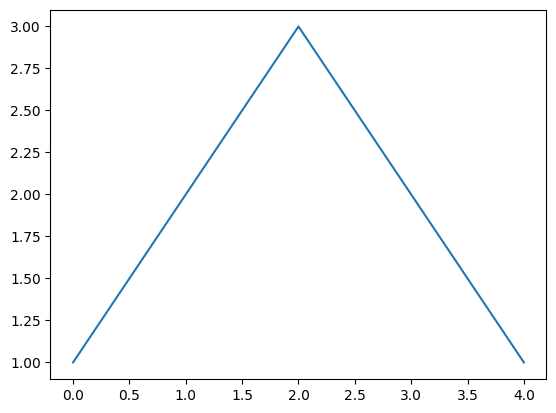

In [23]:
plt.plot(arr)

In [43]:
zoom_rate = 190000 / arr.shape[0]

In [44]:
arr2 = zoom(arr, zoom_rate)

In [56]:
import resampy

In [ ]:
arr_ref = np.array([1, 2, 3, 4, 5, 3, 1])  # shape (6,), reference
arr1 = np.array([1, 5, 2, 3, 7, 2, 1])  # shape (7,), to "compress"
arr2 = np.array([1, 3, 5, 1]) 

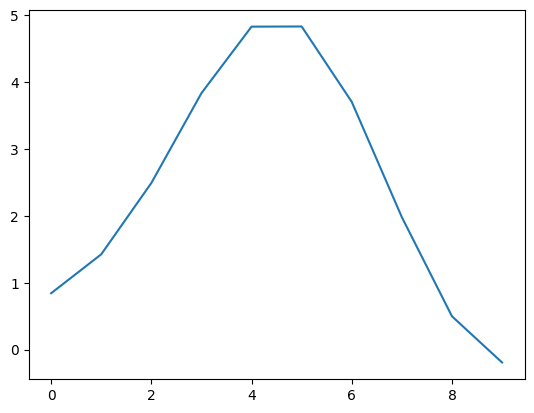

In [70]:
interp_arr = resampy.resample(arr2, 20, 50)
plt.plot(interp_arr)

In [71]:
len(interp_arr)

10

In [84]:
x_mesh = np.linspace(0,1,3)
short_arr= np.sin(x_mesh*2*np.pi)

Text(0.5, 1.0, '"stretch"')

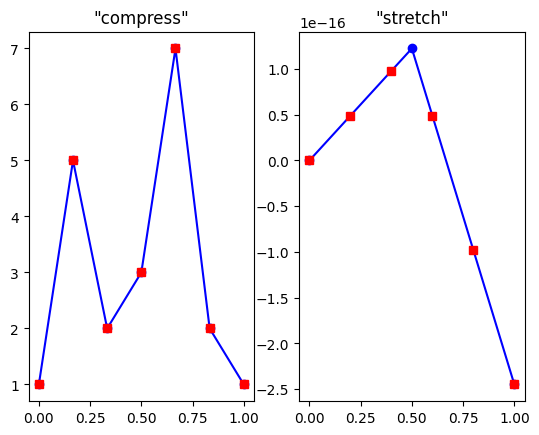

In [85]:
arr_ref = np.array([1, 2, 3, 4, 5, 3, 1])  # shape (6,), reference
arr1 = np.array([1, 5, 2, 3, 7, 2, 1])  # shape (7,), to "compress"
arr2 = np.array([1, 3, 5, 1])        # shape (5,), to "stretch"
arr1_interp = interp.interp1d(np.arange(arr1.size),arr1)
arr1_compress = arr1_interp(np.linspace(0,arr1.size-1,arr_ref.size))
arr2_interp = interp.interp1d(np.arange(short_arr.size),short_arr)
arr2_stretch = arr2_interp(np.linspace(0,short_arr.size-1,6))

# plot the examples, assuming same x_min, x_max for all data
xmin,xmax = 0,1
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(np.linspace(xmin,xmax,arr1.size),arr1,'bo-',
         np.linspace(xmin,xmax,arr1_compress.size),arr1_compress,'rs')
ax2.plot(np.linspace(xmin,xmax,short_arr.size),short_arr,'bo-',
         np.linspace(xmin,xmax,arr2_stretch.size),arr2_stretch,'rs') 
ax1.set_title('"compress"')
ax2.set_title('"stretch"')

In [50]:
import numpy as np

# Assuming you have a 2D array named 'original_array' with shape (100, n)
original_array = np.array([[1,2,3,2,1],[2,3,4,5,6], [0,1,6,2,7]])
print(original_array.shape)
# Define the desired length of the array after interpolation
desired_length = 9

# Calculate the interpolation factor
interpolation_factor = desired_length / original_array.shape[0]

# Create an array of indices for the interpolated array
interpolated_indices = np.arange(desired_length) / interpolation_factor

# Interpolate the original array along the rows
interpolated_array = np.array([np.interp(interpolated_indices, np.arange(original_array.shape[0]), row) for row in original_array])

# Now the 'interpolated_array' has a shape of (1000, n)


(3, 5)


ValueError: fp and xp are not of the same length.

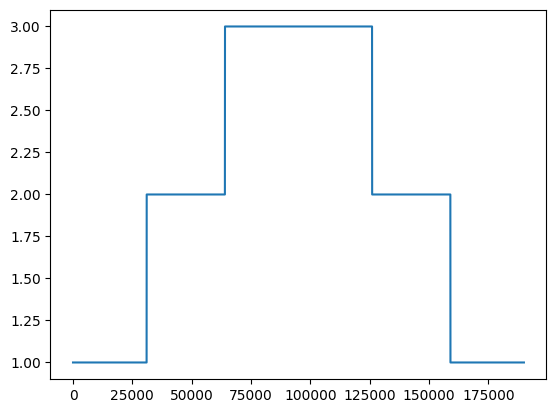

In [45]:
plt.plot(interpolated_array)